2.a,2.b,2.c

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
import matplotlib.pyplot as plt

In [1]:
import json, gzip

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
input_file = '/content/drive/My Drive/mnist_rowmajor.jsonl.gz'
data = []
with gzip.open(input_file, 'rb') as fp:
  for line in fp:
    data.append(json.loads(line.strip()))

In [5]:
test_data = [d for d in data if d['split'] == 'test']
traindev_data = [d for d in data if d['split'] != 'test']
train_data = traindev_data[0:50000]
dev_data = traindev_data[50000:]
from collections import Counter
#print(len(dev_data))
print(Counter([d['label'] for d in train_data]))
print(Counter([d['label'] for d in dev_data]))

Counter({1: 5595, 7: 5201, 3: 5148, 2: 5012, 9: 4977, 0: 4920, 6: 4911, 8: 4864, 4: 4857, 5: 4515})
Counter({1: 1147, 7: 1064, 6: 1007, 0: 1003, 8: 987, 4: 985, 3: 983, 9: 972, 2: 946, 5: 906})


In [8]:
train_labels = torch.LongTensor([x['label'] for x in train_data])
train_fts = torch.FloatTensor([x['image'] for x in train_data])
dev_labels = torch.LongTensor([x['label'] for x in dev_data])
dev_fts = torch.FloatTensor([x['image'] for x in dev_data])
test_labels = torch.LongTensor([x['label'] for x in test_data])
test_fts = torch.FloatTensor([x['image'] for x in test_data])
num_labels = len(set(int(d) for d in train_labels))


In [9]:
def train(model, data_features, data_labels, weight_adjuster,val_features, val_labels,
          loss_fn = nn.CrossEntropyLoss(),
          batch_size=100,
          num_epochs=5,
          epoch_callback=None):
  #loss_fn=nn.BCELoss();
  loss_values = []
  val_loss_values = []
  #data_labels = torch.nn.functional.one_hot(data_labels, num_classes=10).float()
  for epoch in range(num_epochs):
    print("Epoch %d" % epoch)
    epoch_loss = 0.0
    batch_start = 0
    batch_end = min(batch_size, data_features.shape[0])
    num_batches = int(numpy.ceil(data_features.shape[0] / batch_size))
    for batch_idx, batch in enumerate(range(num_batches)):
      batch = data_features[batch_start:batch_end,:]
      weight_adjuster.zero_grad()
      #print(batch.shape,":batch")
      logits = model(batch)

      #print("logits",logits.shape,"logits[0]:",logits[0].shape)
      labels = data_labels[batch_start:batch_end]
      #print(labels.float())
      #labels = torch.nn.functional.one_hot(labels, num_classes=10).float()
      #print(labels.shape)
      #print(logits,"LOGITS")
      #loss = loss_fn(input=logits[0],
      #              target=labels)
      loss = loss_fn(input=logits[0],#.float(),
                    target=labels)
      #print("labels.shape")
      loss.backward()
      weight_adjuster.step()

      epoch_loss += loss.item()

      batch_start = batch_end
      batch_end = batch_end+batch_size
      batch_end = min(batch_end, data_features.shape[0])

    if epoch_callback is not None:
      epoch_callback()

    epoch_loss /= num_batches # average the epoch loss over all batches
    loss_values.append(epoch_loss)
    print("Epoch loss: %f" % epoch_loss)

    with torch.no_grad():
      val_logits = model(val_features)
      val_loss = loss_fn(input=val_logits[0], target=val_labels)
      val_loss_values.append(val_loss.item())
      print("Val loss: %f" % val_loss.item())

  # plot the loss values
  plt.plot(loss_values,label='train loss')
  plt.plot(val_loss_values, label='Val loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss function')
  plt.legend()
  plt.show()

In [10]:
class MyMLP(nn.Module):
  def __init__(self, num_input_dims, num_neurons, num_classes, 
               act_fn=nn.Sigmoid):
    """
    * num_input_dims: the size of each input
    * num_neurons: a list, with an item per hidden layer. Each item is the number of neurons in that hidden layer.
    * num_classes: the number of output classes
    * act_fn: the activation function to apply after every layer. 
              For ease, this model assumes that the *same* function will
              be applied after every layer.

    Example: MyMLP(786, [], 10) defines a logistic regression model with 786 input features,
    10 output classes, and no hidden layers.
    """
    super(MyMLP, self).__init__()
    ins = [num_input_dims]
    print(ins)
    outs = [num_classes]
    print(outs)
    for x in num_neurons:
      ins.append(x)
      outs.append(x)
      print(ins)
      print(outs)
    outs.reverse()
    print(outs,"outs")
    for i,o in zip(ins, outs):
      print(i,":i","o:",o)
    self.layers = nn.ModuleList([nn.Linear(in_features=i,
                                           out_features=o,
                                           bias=True) for i,o in zip(ins, outs)])
    #print(self.layers,"here")
    self.fns = nn.ModuleList([act_fn() for i in range(len(num_neurons))])
    self.fns.append(nn.Softmax())

  def forward(self, input_x):
    ## remember: .forward is called via .__call__ ( layer(...) )
    z = input_x
    #print(z.shape,":Z")
    #print(input_x.shape,"input_x_forward")#[50,784]
    h = None
    for layer, fn in zip(self.layers, self.fns):
      h = layer(z)
      z = fn(h)
    probs = z
    logits = h
    return logits, probs
    #return torch.sigmoid(logits), probs

  def predict(self, X_features):
    _, logits = self.__call__(X_features)
    print(X_features.shape)
    print(logits.shape)
    return logits.argmax(dim=1)

In [11]:
print(MyMLP(64, [], 10))
print(MyMLP(64, [50], 10))

[64]
[10]
[10] outs
64 :i o: 10
MyMLP(
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=10, bias=True)
  )
  (fns): ModuleList(
    (0): Softmax(dim=None)
  )
)
[64]
[10]
[64, 50]
[10, 50]
[50, 10] outs
64 :i o: 50
50 :i o: 10
MyMLP(
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
  (fns): ModuleList(
    (0): Sigmoid()
    (1): Softmax(dim=None)
  )
)


In [12]:
print(MyMLP(786, [], 10))
print(MyMLP(786, [50], 10))

[786]
[10]
[10] outs
786 :i o: 10
MyMLP(
  (layers): ModuleList(
    (0): Linear(in_features=786, out_features=10, bias=True)
  )
  (fns): ModuleList(
    (0): Softmax(dim=None)
  )
)
[786]
[10]
[786, 50]
[10, 50]
[50, 10] outs
786 :i o: 50
50 :i o: 10
MyMLP(
  (layers): ModuleList(
    (0): Linear(in_features=786, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
  (fns): ModuleList(
    (0): Sigmoid()
    (1): Softmax(dim=None)
  )
)


In [13]:
def predict_callback(actual, input_fts, model):
  
  def aux():
    f1 = f1_score(y_true=actual, y_pred=model.predict(input_fts), average='micro')
    print("f1 score:",f1)
  return aux
  


[784]
[10]
[10] outs
784 :i o: 10
Epoch 0


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9054
Epoch loss: 0.597267
Val loss: 0.364126
Epoch 1


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9148
Epoch loss: 0.341045
Val loss: 0.313674
Epoch 2


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9186
Epoch loss: 0.307201
Val loss: 0.295451
Epoch 3


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9206
Epoch loss: 0.291068
Val loss: 0.286203
Epoch 4


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9216
Epoch loss: 0.281168
Val loss: 0.280694
Epoch 5


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9226
Epoch loss: 0.274269
Val loss: 0.277078
Epoch 6


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9236
Epoch loss: 0.269073
Val loss: 0.274553
Epoch 7


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9238
Epoch loss: 0.264953
Val loss: 0.272715
Epoch 8


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9249
Epoch loss: 0.261567
Val loss: 0.271342
Epoch 9


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9257
Epoch loss: 0.258709
Val loss: 0.270302
Epoch 10


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9261999999999999
Epoch loss: 0.256249
Val loss: 0.269509
Epoch 11


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9264
Epoch loss: 0.254098
Val loss: 0.268906
Epoch 12


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9265
Epoch loss: 0.252193
Val loss: 0.268451
Epoch 13


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9269
Epoch loss: 0.250488
Val loss: 0.268117
Epoch 14


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9271
Epoch loss: 0.248948
Val loss: 0.267879
Epoch 15


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9271
Epoch loss: 0.247547
Val loss: 0.267722
Epoch 16


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9271
Epoch loss: 0.246264
Val loss: 0.267633
Epoch 17


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9271999999999999
Epoch loss: 0.245082
Val loss: 0.267599
Epoch 18


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9271999999999999
Epoch loss: 0.243988
Val loss: 0.267613
Epoch 19


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9271999999999999
Epoch loss: 0.242971
Val loss: 0.267668


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


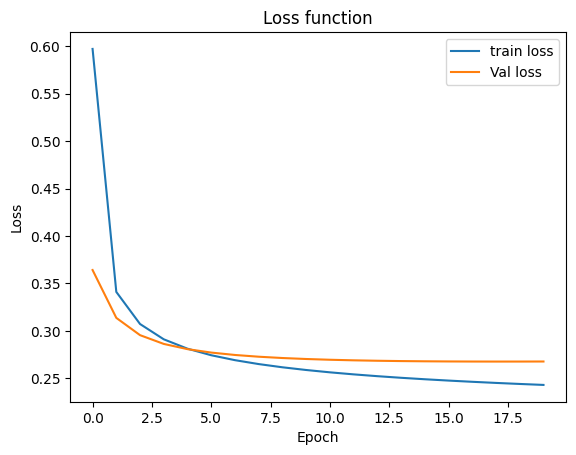

In [14]:
model = MyMLP(num_input_dims=train_fts.shape[1], 
              num_neurons=[],
              num_classes=num_labels)
weight_adjuster = torch.optim.Adam(model.parameters(),lr=0.001)

train(model, train_fts, train_labels, 
      weight_adjuster=weight_adjuster,
      num_epochs=20, batch_size=70,val_features=dev_fts,val_labels=dev_labels,
      epoch_callback=predict_callback(actual=dev_labels,
                                      input_fts=dev_fts,
                                      model=model))

In [15]:
x_pred=model.predict(test_fts)
import numpy as np

matches = [1 if a == b else 0 for a, b in zip(x_pred, test_labels)]
total_matches = sum(matches)

print(f"Accuracy: {total_matches/10000:.4f}%")

torch.Size([10000, 784])
torch.Size([10000, 10])
Accuracy: 0.9247%


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


In [17]:
#will run longer     784->512->64
class Autoencoder2(nn.Module):
  def __init__(self, num_input_dims, num_hidden_dims,
               act_fn=nn.Sigmoid):
    super(Autoencoder2, self).__init__()
    print(num_input_dims)

    self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(True),
            nn.Linear(512, 64),
            nn.Softmax()
        )
    self.decoder = nn.Sequential(
            nn.Linear(64, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            #nn.ReLU(True)
            nn.Softmax()
        )

  def forward(self, x):
    #batch_size = x.size(0)
    #x = x.view(batch_size, -1)
    #x = x.view(-1, 784)
    xx = self.encoder(x)
    #print(xx.shape)
    #x = x.view(-1, 64)
    x = self.decoder(xx)
    #print(x.shape)
    return xx,x
    #raise NotImplementedError("You must implement this.")

In [18]:
autoencoder2 = Autoencoder2(784,64) # intentionally not providing arguments: You fill in!
autoencoder_adjuster2 = torch.optim.Adam(autoencoder2.parameters())
with torch.no_grad():
  autoencoder_train_fts = autoencoder2(train_fts)[0]
  autoencoder_dev_fts = autoencoder2(dev_fts)[0]
print(autoencoder_train_fts.shape)
print(train_fts)

784


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([50000, 64])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


[64]
[10]
[10] outs
64 :i o: 10
Epoch 0


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1147
Epoch loss: 2.300920
Val loss: 2.299194
Epoch 1


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1147
Epoch loss: 2.298667
Val loss: 2.297263
Epoch 2


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1147
Epoch loss: 2.296753
Val loss: 2.295335
Epoch 3


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1147
Epoch loss: 2.294841
Val loss: 2.293409
Epoch 4


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1147
Epoch loss: 2.292932
Val loss: 2.291485
Epoch 5


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1147
Epoch loss: 2.291025
Val loss: 2.289564
Epoch 6


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1147
Epoch loss: 2.289121
Val loss: 2.287645
Epoch 7


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1147
Epoch loss: 2.287219
Val loss: 2.285729
Epoch 8


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1155
Epoch loss: 2.285319
Val loss: 2.283815
Epoch 9


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.11760000000000001
Epoch loss: 2.283421
Val loss: 2.281903
Epoch 10


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1222
Epoch loss: 2.281526
Val loss: 2.279993
Epoch 11


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1274
Epoch loss: 2.279633
Val loss: 2.278086
Epoch 12


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1337
Epoch loss: 2.277743
Val loss: 2.276182
Epoch 13


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1412
Epoch loss: 2.275855
Val loss: 2.274280
Epoch 14


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1498
Epoch loss: 2.273969
Val loss: 2.272380
Epoch 15


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1604
Epoch loss: 2.272086
Val loss: 2.270482
Epoch 16


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1702
Epoch loss: 2.270205
Val loss: 2.268587
Epoch 17


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1815
Epoch loss: 2.268326
Val loss: 2.266694
Epoch 18


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.1898
Epoch loss: 2.266449
Val loss: 2.264804
Epoch 19


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2004
Epoch loss: 2.264575
Val loss: 2.262916
Epoch 20


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2095
Epoch loss: 2.262704
Val loss: 2.261030
Epoch 21


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2194
Epoch loss: 2.260834
Val loss: 2.259147
Epoch 22


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2285
Epoch loss: 2.258967
Val loss: 2.257266
Epoch 23


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2365
Epoch loss: 2.257103
Val loss: 2.255387
Epoch 24


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2444
Epoch loss: 2.255240
Val loss: 2.253510
Epoch 25


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2532
Epoch loss: 2.253380
Val loss: 2.251637
Epoch 26


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2611
Epoch loss: 2.251523
Val loss: 2.249765
Epoch 27


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2684
Epoch loss: 2.249667
Val loss: 2.247896
Epoch 28


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2768
Epoch loss: 2.247814
Val loss: 2.246029
Epoch 29


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2855
Epoch loss: 2.245964
Val loss: 2.244164
Epoch 30


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2937
Epoch loss: 2.244115
Val loss: 2.242302
Epoch 31


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3013
Epoch loss: 2.242269
Val loss: 2.240442
Epoch 32


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3076
Epoch loss: 2.240426
Val loss: 2.238585
Epoch 33


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3142
Epoch loss: 2.238584
Val loss: 2.236729
Epoch 34


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3214
Epoch loss: 2.236745
Val loss: 2.234877
Epoch 35


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3287
Epoch loss: 2.234908
Val loss: 2.233026
Epoch 36


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3353
Epoch loss: 2.233074
Val loss: 2.231178
Epoch 37


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3425
Epoch loss: 2.231242
Val loss: 2.229333
Epoch 38


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3482
Epoch loss: 2.229412
Val loss: 2.227489
Epoch 39


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3552
Epoch loss: 2.227585
Val loss: 2.225648
Epoch 40


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3606
Epoch loss: 2.225760
Val loss: 2.223809
Epoch 41


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3661
Epoch loss: 2.223937
Val loss: 2.221973
Epoch 42


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3726
Epoch loss: 2.222116
Val loss: 2.220139
Epoch 43


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3785
Epoch loss: 2.220298
Val loss: 2.218307
Epoch 44


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3832999999999999
Epoch loss: 2.218482
Val loss: 2.216477
Epoch 45


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3887
Epoch loss: 2.216669
Val loss: 2.214650
Epoch 46


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3952
Epoch loss: 2.214857
Val loss: 2.212825
Epoch 47


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.3994
Epoch loss: 2.213048
Val loss: 2.211003
Epoch 48


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.405
Epoch loss: 2.211242
Val loss: 2.209183
Epoch 49


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.411
Epoch loss: 2.209437
Val loss: 2.207365
Epoch 50


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4155
Epoch loss: 2.207635
Val loss: 2.205549
Epoch 51


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4208
Epoch loss: 2.205836
Val loss: 2.203736
Epoch 52


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4252
Epoch loss: 2.204038
Val loss: 2.201925
Epoch 53


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.429
Epoch loss: 2.202243
Val loss: 2.200116
Epoch 54


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4331
Epoch loss: 2.200450
Val loss: 2.198310
Epoch 55


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4374
Epoch loss: 2.198660
Val loss: 2.196507
Epoch 56


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4415
Epoch loss: 2.196872
Val loss: 2.194705
Epoch 57


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4457
Epoch loss: 2.195086
Val loss: 2.192905
Epoch 58


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.44810000000000005
Epoch loss: 2.193302
Val loss: 2.191109
Epoch 59


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4531
Epoch loss: 2.191521
Val loss: 2.189314
Epoch 60


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4566
Epoch loss: 2.189742
Val loss: 2.187522
Epoch 61


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4597
Epoch loss: 2.187965
Val loss: 2.185732
Epoch 62


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4633
Epoch loss: 2.186190
Val loss: 2.183944
Epoch 63


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4677
Epoch loss: 2.184418
Val loss: 2.182159
Epoch 64


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4712
Epoch loss: 2.182648
Val loss: 2.180376
Epoch 65


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4736
Epoch loss: 2.180881
Val loss: 2.178595
Epoch 66


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4769
Epoch loss: 2.179115
Val loss: 2.176816
Epoch 67


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4802
Epoch loss: 2.177352
Val loss: 2.175040
Epoch 68


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4829
Epoch loss: 2.175592
Val loss: 2.173266
Epoch 69


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4859
Epoch loss: 2.173833
Val loss: 2.171494
Epoch 70


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4884
Epoch loss: 2.172077
Val loss: 2.169725
Epoch 71


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4915
Epoch loss: 2.170323
Val loss: 2.167958
Epoch 72


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4938
Epoch loss: 2.168571
Val loss: 2.166193
Epoch 73


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4966
Epoch loss: 2.166822
Val loss: 2.164431
Epoch 74


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4994
Epoch loss: 2.165075
Val loss: 2.162671
Epoch 75


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5019
Epoch loss: 2.163330
Val loss: 2.160913
Epoch 76


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5043
Epoch loss: 2.161587
Val loss: 2.159157
Epoch 77


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5061
Epoch loss: 2.159847
Val loss: 2.157404
Epoch 78


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5091
Epoch loss: 2.158109
Val loss: 2.155653
Epoch 79


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.511
Epoch loss: 2.156373
Val loss: 2.153904
Epoch 80


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5141
Epoch loss: 2.154640
Val loss: 2.152158
Epoch 81


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5167
Epoch loss: 2.152908
Val loss: 2.150414
Epoch 82


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5185
Epoch loss: 2.151179
Val loss: 2.148672
Epoch 83


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5193
Epoch loss: 2.149453
Val loss: 2.146932
Epoch 84


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5216
Epoch loss: 2.147728
Val loss: 2.145195
Epoch 85


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5242
Epoch loss: 2.146006
Val loss: 2.143460
Epoch 86


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5266
Epoch loss: 2.144286
Val loss: 2.141727
Epoch 87


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5286
Epoch loss: 2.142568
Val loss: 2.139997
Epoch 88


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5304
Epoch loss: 2.140853
Val loss: 2.138268
Epoch 89


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5325
Epoch loss: 2.139140
Val loss: 2.136543
Epoch 90


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5344
Epoch loss: 2.137429
Val loss: 2.134819
Epoch 91


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5356
Epoch loss: 2.135720
Val loss: 2.133097
Epoch 92


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5369
Epoch loss: 2.134014
Val loss: 2.131378
Epoch 93


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5393
Epoch loss: 2.132309
Val loss: 2.129662
Epoch 94


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5407
Epoch loss: 2.130607
Val loss: 2.127947
Epoch 95


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5415
Epoch loss: 2.128908
Val loss: 2.126235
Epoch 96


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5436
Epoch loss: 2.127210
Val loss: 2.124524
Epoch 97


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.545
Epoch loss: 2.125515
Val loss: 2.122817
Epoch 98


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5458
Epoch loss: 2.123822
Val loss: 2.121111
Epoch 99


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5474
Epoch loss: 2.122131
Val loss: 2.119408
Epoch 100


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5485
Epoch loss: 2.120443
Val loss: 2.117707
Epoch 101


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5499
Epoch loss: 2.118756
Val loss: 2.116008
Epoch 102


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5514
Epoch loss: 2.117072
Val loss: 2.114311
Epoch 103


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5524
Epoch loss: 2.115390
Val loss: 2.112617
Epoch 104


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5536
Epoch loss: 2.113711
Val loss: 2.110925
Epoch 105


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5551
Epoch loss: 2.112033
Val loss: 2.109235
Epoch 106


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5561
Epoch loss: 2.110358
Val loss: 2.107548
Epoch 107


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5575
Epoch loss: 2.108685
Val loss: 2.105862
Epoch 108


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5591
Epoch loss: 2.107015
Val loss: 2.104179
Epoch 109


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5604
Epoch loss: 2.105346
Val loss: 2.102499
Epoch 110


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5617
Epoch loss: 2.103680
Val loss: 2.100820
Epoch 111


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5624
Epoch loss: 2.102016
Val loss: 2.099144
Epoch 112


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5641
Epoch loss: 2.100354
Val loss: 2.097469
Epoch 113


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5648
Epoch loss: 2.098695
Val loss: 2.095798
Epoch 114


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5659
Epoch loss: 2.097037
Val loss: 2.094128
Epoch 115


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.567
Epoch loss: 2.095382
Val loss: 2.092461
Epoch 116


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5682
Epoch loss: 2.093729
Val loss: 2.090795
Epoch 117


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5692
Epoch loss: 2.092078
Val loss: 2.089132
Epoch 118


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5699
Epoch loss: 2.090430
Val loss: 2.087471
Epoch 119


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5709
Epoch loss: 2.088783
Val loss: 2.085813
Epoch 120


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.572
Epoch loss: 2.087139
Val loss: 2.084157
Epoch 121


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5734
Epoch loss: 2.085497
Val loss: 2.082503
Epoch 122


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.574
Epoch loss: 2.083858
Val loss: 2.080851
Epoch 123


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5751
Epoch loss: 2.082220
Val loss: 2.079201
Epoch 124


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5765
Epoch loss: 2.080585
Val loss: 2.077554
Epoch 125


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5777
Epoch loss: 2.078952
Val loss: 2.075909
Epoch 126


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5787
Epoch loss: 2.077321
Val loss: 2.074266
Epoch 127


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5795
Epoch loss: 2.075692
Val loss: 2.072625
Epoch 128


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5807
Epoch loss: 2.074065
Val loss: 2.070986
Epoch 129


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.582
Epoch loss: 2.072441
Val loss: 2.069350
Epoch 130


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5828
Epoch loss: 2.070819
Val loss: 2.067716
Epoch 131


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.584
Epoch loss: 2.069199
Val loss: 2.066084
Epoch 132


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5849
Epoch loss: 2.067581
Val loss: 2.064454
Epoch 133


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5855
Epoch loss: 2.065966
Val loss: 2.062827
Epoch 134


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5862
Epoch loss: 2.064352
Val loss: 2.061201
Epoch 135


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5872
Epoch loss: 2.062741
Val loss: 2.059578
Epoch 136


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5876
Epoch loss: 2.061132
Val loss: 2.057957
Epoch 137


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5886
Epoch loss: 2.059525
Val loss: 2.056338
Epoch 138


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5891
Epoch loss: 2.057920
Val loss: 2.054722
Epoch 139


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5901
Epoch loss: 2.056318
Val loss: 2.053108
Epoch 140


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5909
Epoch loss: 2.054717
Val loss: 2.051496
Epoch 141


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5913
Epoch loss: 2.053119
Val loss: 2.049886
Epoch 142


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5925
Epoch loss: 2.051523
Val loss: 2.048278
Epoch 143


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5932
Epoch loss: 2.049929
Val loss: 2.046672
Epoch 144


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5941
Epoch loss: 2.048337
Val loss: 2.045069
Epoch 145


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5944
Epoch loss: 2.046748
Val loss: 2.043468
Epoch 146


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5952
Epoch loss: 2.045160
Val loss: 2.041868
Epoch 147


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5956
Epoch loss: 2.043575
Val loss: 2.040271
Epoch 148


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5966
Epoch loss: 2.041992
Val loss: 2.038677
Epoch 149


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5977
Epoch loss: 2.040411
Val loss: 2.037084


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


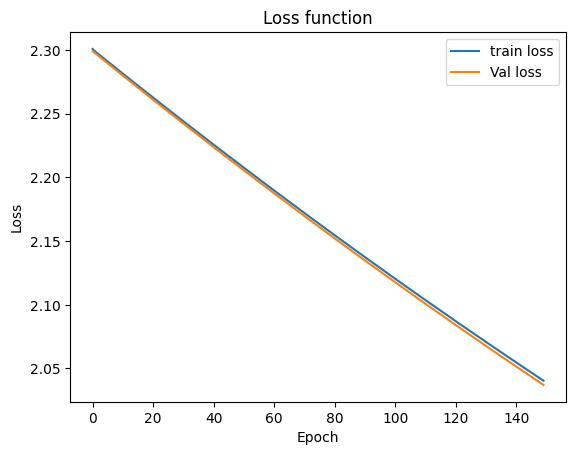

In [19]:
model3 = MyMLP(num_input_dims=autoencoder_train_fts.shape[1], 
               num_neurons=[],
               num_classes=num_labels)
weight_adjuster2 = torch.optim.Adam(model3.parameters())
train(model3, autoencoder_train_fts, train_labels, 
      weight_adjuster=weight_adjuster2,val_features=autoencoder_dev_fts,val_labels=dev_labels,
      num_epochs=150, batch_size=25,
      epoch_callback=predict_callback(actual=dev_labels,
                                      input_fts=autoencoder_dev_fts,
                                      model=model3))

In [20]:
x_pred=model3.predict(autoencoder2(test_fts)[0])
import numpy as np

matches = [1 if a == b else 0 for a, b in zip(x_pred, test_labels)]
total_matches = sum(matches)

print(f"Accuracy: {total_matches/10000:.4f}%")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([10000, 64])
torch.Size([10000, 10])
Accuracy: 0.6099%


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


In [21]:
#Reduced dimension returns encoded  Encoder 64
class Autoencoder1(nn.Module):
    def __init__(self, num_input_dims, num_hidden_dims, act_fn=nn.Sigmoid):
        super(Autoencoder1, self).__init__()
        self.encoder = nn.Linear(num_input_dims, num_hidden_dims)
        self.activation = nn.ReLU
        self.decoder = nn.Linear(num_hidden_dims, num_input_dims)
        self.activation = act_fn()

    def forward(self, x):
        #x = self.encoder(x)
        #x = self.activation(x)
        encoded = self.encoder(x)
        encoded = self.activation(encoded)
        decoded = self.decoder(encoded)
        decoded = self.activation(decoded)
        return  encoded,decoded
        #return x

In [22]:
#Back to original returns decoded  Decoder
class Autoencoder(nn.Module):
    def __init__(self, num_input_dims, num_hidden_dims, act_fn=nn.Sigmoid):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(num_input_dims, num_hidden_dims)
        self.decoder = nn.Linear(num_hidden_dims, num_input_dims)
        self.activation = act_fn()

    def forward(self, x):
        #x = self.encoder(x)
        #x = self.activation(x)
        encoded = self.encoder(x)
        encoded = self.activation(encoded)
        decoded = self.decoder(encoded)
        decoded = self.activation(decoded)
        return  decoded,encoded
        #return x

torch.Size([50000, 784]) trainfts
Epoch 0
Epoch loss: 0.281301
Val loss: 0.248862
Epoch 1
Epoch loss: 0.231718
Val loss: 0.214655
Epoch 2
Epoch loss: 0.201857
Val loss: 0.190175
Epoch 3
Epoch loss: 0.181030
Val loss: 0.171697
Epoch 4
Epoch loss: 0.165095
Val loss: 0.158641
Epoch 5
Epoch loss: 0.153961
Val loss: 0.149223
Epoch 6
Epoch loss: 0.145657
Val loss: 0.141930
Epoch 7
Epoch loss: 0.138955
Val loss: 0.135686
Epoch 8
Epoch loss: 0.133128
Val loss: 0.130319
Epoch 9
Epoch loss: 0.128283
Val loss: 0.125980
Epoch 10
Epoch loss: 0.124417
Val loss: 0.122540
Epoch 11
Epoch loss: 0.121346
Val loss: 0.119803
Epoch 12
Epoch loss: 0.118875
Val loss: 0.117586
Epoch 13
Epoch loss: 0.116738
Val loss: 0.115490
Epoch 14
Epoch loss: 0.114611
Val loss: 0.113353
Epoch 15
Epoch loss: 0.112490
Val loss: 0.111306
Epoch 16
Epoch loss: 0.110262
Val loss: 0.108841
Epoch 17
Epoch loss: 0.107371
Val loss: 0.105350
Epoch 18
Epoch loss: 0.103224
Val loss: 0.100809
Epoch 19
Epoch loss: 0.098749
Val loss: 0.096

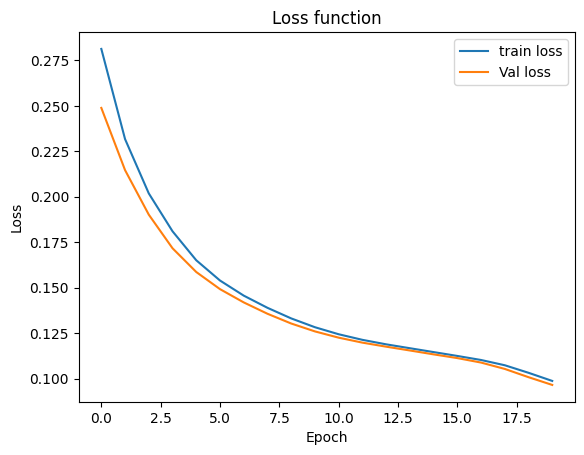

In [23]:
#evaluating after restoring the model
autoencoder = Autoencoder(784,64) # intentionally not providing arguments: You fill in!
autoencoder_adjuster = torch.optim.Adam(autoencoder.parameters())
print(train_fts.shape,"trainfts")
train(autoencoder, train_fts, train_fts,
      loss_fn=nn.BCELoss(), # Same as with the loss function
      weight_adjuster=autoencoder_adjuster,val_features=dev_fts,val_labels=dev_fts,
      num_epochs=20, batch_size=100)

Epoch 0


<ipython-input-22-400b3ad21ccd>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  encoded = self.activation(encoded)
<ipython-input-22-400b3ad21ccd>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  decoded = self.activation(decoded)


Epoch loss: 0.815294
Val loss: 0.779320
Epoch 1
Epoch loss: 0.767872
Val loss: 0.758838
Epoch 2
Epoch loss: 0.755636
Val loss: 0.751550
Epoch 3
Epoch loss: 0.750348
Val loss: 0.747760
Epoch 4
Epoch loss: 0.747410
Val loss: 0.745483
Epoch 5
Epoch loss: 0.745557
Val loss: 0.743970
Epoch 6
Epoch loss: 0.744275
Val loss: 0.742888
Epoch 7
Epoch loss: 0.743330
Val loss: 0.742070
Epoch 8
Epoch loss: 0.742600
Val loss: 0.741430
Epoch 9
Epoch loss: 0.742019
Val loss: 0.740913
Epoch 10
Epoch loss: 0.741546
Val loss: 0.740487
Epoch 11
Epoch loss: 0.741153
Val loss: 0.740130
Epoch 12
Epoch loss: 0.740823
Val loss: 0.739829
Epoch 13
Epoch loss: 0.740543
Val loss: 0.739563
Epoch 14
Epoch loss: 0.738233
Val loss: 0.735351
Epoch 15
Epoch loss: 0.735379
Val loss: 0.733605
Epoch 16
Epoch loss: 0.734108
Val loss: 0.732629
Epoch 17
Epoch loss: 0.733306
Val loss: 0.731947
Epoch 18
Epoch loss: 0.732716
Val loss: 0.731419
Epoch 19
Epoch loss: 0.732246
Val loss: 0.730989


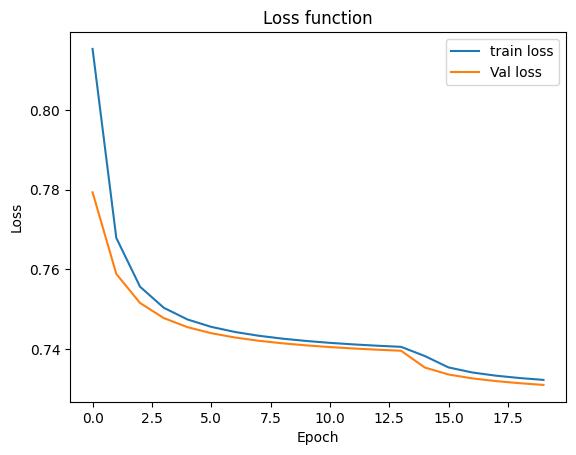

In [24]:
autoencoderRelu = Autoencoder(784,64,nn.Softmax) # intentionally not providing arguments: You fill in!
autoencoder_adjuster = torch.optim.Adam(autoencoderRelu.parameters(),0.001)
train(autoencoderRelu, train_fts, train_fts,
      loss_fn=nn.BCELoss(), # Same as with the loss function
      weight_adjuster=autoencoder_adjuster,val_features=dev_fts,val_labels=dev_fts,
      num_epochs=20, batch_size=100)

In [25]:
autoencoder1 = Autoencoder1(784,64) # intentionally not providing arguments: You fill in!
autoencoder_adjuster1 = torch.optim.Adam(autoencoder1.parameters())
with torch.no_grad():
  autoencoder_train_fts = autoencoder1(train_fts)[0]
  autoencoder_dev_fts = autoencoder1(dev_fts)[0]
print(autoencoder_train_fts.shape)
print(train_fts)

torch.Size([50000, 64])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


[64]
[10]
[10] outs
64 :i o: 10
Epoch 0


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.2881
Epoch loss: 2.270973
Val loss: 2.238735
Epoch 1


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.4683
Epoch loss: 2.212757
Val loss: 2.181941
Epoch 2


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5513
Epoch loss: 2.157313
Val loss: 2.127524
Epoch 3


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.5887
Epoch loss: 2.104196
Val loss: 2.075404
Epoch 4


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6088
Epoch loss: 2.053325
Val loss: 2.025497
Epoch 5


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6232
Epoch loss: 2.004619
Val loss: 1.977721
Epoch 6


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6343
Epoch loss: 1.957999
Val loss: 1.932002
Epoch 7


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6434
Epoch loss: 1.913391
Val loss: 1.888263
Epoch 8


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6507
Epoch loss: 1.870722
Val loss: 1.846433
Epoch 9


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.658
Epoch loss: 1.829920
Val loss: 1.806437
Epoch 10


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6628
Epoch loss: 1.790913
Val loss: 1.768204
Epoch 11


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6665
Epoch loss: 1.753630
Val loss: 1.731662
Epoch 12


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6716
Epoch loss: 1.718001
Val loss: 1.696741
Epoch 13


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6749
Epoch loss: 1.683954
Val loss: 1.663368
Epoch 14


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6784
Epoch loss: 1.651420
Val loss: 1.631477
Epoch 15


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6822
Epoch loss: 1.620330
Val loss: 1.600997
Epoch 16


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6853
Epoch loss: 1.590618
Val loss: 1.571863
Epoch 17


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6883
Epoch loss: 1.562218
Val loss: 1.544011
Epoch 18


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6922
Epoch loss: 1.535067
Val loss: 1.517378
Epoch 19


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.695
Epoch loss: 1.509104
Val loss: 1.491903
Epoch 20


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.6976
Epoch loss: 1.484270
Val loss: 1.467531
Epoch 21


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7007
Epoch loss: 1.460508
Val loss: 1.444203
Epoch 22


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7028
Epoch loss: 1.437765
Val loss: 1.421870
Epoch 23


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7052
Epoch loss: 1.415988
Val loss: 1.400478
Epoch 24


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7073
Epoch loss: 1.395128
Val loss: 1.379980
Epoch 25


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7095
Epoch loss: 1.375138
Val loss: 1.360331
Epoch 26


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7111
Epoch loss: 1.355974
Val loss: 1.341486
Epoch 27


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7127
Epoch loss: 1.337593
Val loss: 1.323405
Epoch 28


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7146
Epoch loss: 1.319955
Val loss: 1.306048
Epoch 29


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7158999999999999
Epoch loss: 1.303021
Val loss: 1.289378
Epoch 30


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7173
Epoch loss: 1.286756
Val loss: 1.273360
Epoch 31


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7189000000000001
Epoch loss: 1.271125
Val loss: 1.257961
Epoch 32


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.72
Epoch loss: 1.256096
Val loss: 1.243150
Epoch 33


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7213000000000002
Epoch loss: 1.241639
Val loss: 1.228896
Epoch 34


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7229
Epoch loss: 1.227724
Val loss: 1.215172
Epoch 35


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7247
Epoch loss: 1.214325
Val loss: 1.201951
Epoch 36


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7261000000000001
Epoch loss: 1.201415
Val loss: 1.189208
Epoch 37


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7276
Epoch loss: 1.188972
Val loss: 1.176920
Epoch 38


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7296
Epoch loss: 1.176970
Val loss: 1.165064
Epoch 39


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7312
Epoch loss: 1.165390
Val loss: 1.153620
Epoch 40


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7324
Epoch loss: 1.154210
Val loss: 1.142567
Epoch 41


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7333
Epoch loss: 1.143412
Val loss: 1.131887
Epoch 42


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7345
Epoch loss: 1.132977
Val loss: 1.121562
Epoch 43


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7357
Epoch loss: 1.122887
Val loss: 1.111576
Epoch 44


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7373
Epoch loss: 1.113128
Val loss: 1.101912
Epoch 45


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7384
Epoch loss: 1.103683
Val loss: 1.092556
Epoch 46


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7391
Epoch loss: 1.094538
Val loss: 1.083494
Epoch 47


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7402
Epoch loss: 1.085680
Val loss: 1.074713
Epoch 48


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7417
Epoch loss: 1.077095
Val loss: 1.066200
Epoch 49


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7427
Epoch loss: 1.068771
Val loss: 1.057942
Epoch 50


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7433
Epoch loss: 1.060697
Val loss: 1.049930
Epoch 51


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7447
Epoch loss: 1.052862
Val loss: 1.042151
Epoch 52


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7451
Epoch loss: 1.045256
Val loss: 1.034598
Epoch 53


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.746
Epoch loss: 1.037868
Val loss: 1.027258
Epoch 54


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7471
Epoch loss: 1.030690
Val loss: 1.020125
Epoch 55


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7482
Epoch loss: 1.023713
Val loss: 1.013188
Epoch 56


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7493
Epoch loss: 1.016928
Val loss: 1.006440
Epoch 57


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7505
Epoch loss: 1.010327
Val loss: 0.999874
Epoch 58


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7512
Epoch loss: 1.003904
Val loss: 0.993482
Epoch 59


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.752
Epoch loss: 0.997651
Val loss: 0.987257
Epoch 60


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7532
Epoch loss: 0.991561
Val loss: 0.981193
Epoch 61


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7548
Epoch loss: 0.985629
Val loss: 0.975283
Epoch 62


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7559000000000001
Epoch loss: 0.979847
Val loss: 0.969521
Epoch 63


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.757
Epoch loss: 0.974210
Val loss: 0.963903
Epoch 64


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7578999999999999
Epoch loss: 0.968712
Val loss: 0.958421
Epoch 65


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7590000000000001
Epoch loss: 0.963349
Val loss: 0.953072
Epoch 66


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7596
Epoch loss: 0.958116
Val loss: 0.947851
Epoch 67


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7602
Epoch loss: 0.953006
Val loss: 0.942752
Epoch 68


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7607999999999999
Epoch loss: 0.948018
Val loss: 0.937772
Epoch 69


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7612
Epoch loss: 0.943144
Val loss: 0.932906
Epoch 70


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7619
Epoch loss: 0.938383
Val loss: 0.928150
Epoch 71


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7624
Epoch loss: 0.933729
Val loss: 0.923500
Epoch 72


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7631000000000001
Epoch loss: 0.929180
Val loss: 0.918953
Epoch 73


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7635
Epoch loss: 0.924731
Val loss: 0.914506
Epoch 74


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7645
Epoch loss: 0.920379
Val loss: 0.910154
Epoch 75


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7651
Epoch loss: 0.916120
Val loss: 0.905895
Epoch 76


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7658000000000001
Epoch loss: 0.911953
Val loss: 0.901725
Epoch 77


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7662
Epoch loss: 0.907873
Val loss: 0.897643
Epoch 78


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7668000000000001
Epoch loss: 0.903878
Val loss: 0.893644
Epoch 79


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.768
Epoch loss: 0.899966
Val loss: 0.889727
Epoch 80


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7693
Epoch loss: 0.896132
Val loss: 0.885888
Epoch 81


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7701
Epoch loss: 0.892376
Val loss: 0.882125
Epoch 82


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7708
Epoch loss: 0.888695
Val loss: 0.878437
Epoch 83


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7715000000000001
Epoch loss: 0.885085
Val loss: 0.874820
Epoch 84


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.772
Epoch loss: 0.881546
Val loss: 0.871272
Epoch 85


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7724
Epoch loss: 0.878075
Val loss: 0.867792
Epoch 86


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7727
Epoch loss: 0.874670
Val loss: 0.864377
Epoch 87


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7733
Epoch loss: 0.871329
Val loss: 0.861026
Epoch 88


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7732
Epoch loss: 0.868050
Val loss: 0.857737
Epoch 89


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7736
Epoch loss: 0.864832
Val loss: 0.854507
Epoch 90


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7739
Epoch loss: 0.861672
Val loss: 0.851335
Epoch 91


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7746999999999999
Epoch loss: 0.858569
Val loss: 0.848220
Epoch 92


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7746999999999999
Epoch loss: 0.855521
Val loss: 0.845160
Epoch 93


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7753
Epoch loss: 0.852527
Val loss: 0.842154
Epoch 94


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7755
Epoch loss: 0.849586
Val loss: 0.839199
Epoch 95


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7763
Epoch loss: 0.846695
Val loss: 0.836295
Epoch 96


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.777
Epoch loss: 0.843854
Val loss: 0.833440
Epoch 97


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7778
Epoch loss: 0.841061
Val loss: 0.830633
Epoch 98


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.778
Epoch loss: 0.838315
Val loss: 0.827873
Epoch 99


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7787000000000001
Epoch loss: 0.835614
Val loss: 0.825158


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


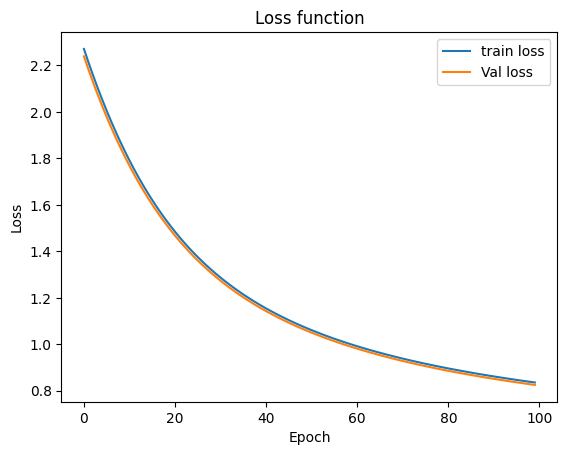

In [26]:
#AFter reducing dimensionality using Autoencoder1
model2 = MyMLP(num_input_dims=autoencoder_train_fts.shape[1], 
               num_neurons=[],
               num_classes=num_labels)
weight_adjuster2 = torch.optim.Adam(model2.parameters())
train(model2, autoencoder_train_fts, train_labels, val_features=autoencoder_dev_fts,val_labels=dev_labels,
      weight_adjuster=weight_adjuster2,
      num_epochs=100, batch_size=80,
      epoch_callback=predict_callback(actual=dev_labels,
                                      input_fts=autoencoder_dev_fts,
                                      model=model2))

In [27]:
x_pred=model2.predict(autoencoder1(test_fts)[0])
import numpy as np

matches = [1 if a == b else 0 for a, b in zip(x_pred, test_labels)]
total_matches = sum(matches)

print(f"Accuracy: {total_matches/10000:.4f}%")

<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
Accuracy: 0.7872%


In [28]:
#config with tanh 64
autoencoder11 = Autoencoder1(784,64,nn.Tanh ) # intentionally not providing arguments: You fill in!
autoencoder_adjuster11 = torch.optim.Adam(autoencoder11.parameters())
with torch.no_grad():
  autoencoder_train_fts = autoencoder11(train_fts)[0]
  autoencoder_dev_fts = autoencoder11(dev_fts)[0]


[64]
[10]
[10] outs
64 :i o: 10
Epoch 0


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7452
Epoch loss: 1.778062
Val loss: 1.393979
Epoch 1


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7807
Epoch loss: 1.198341
Val loss: 1.041522
Epoch 2


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.7974
Epoch loss: 0.954629
Val loss: 0.872083
Epoch 3


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8079
Epoch loss: 0.826181
Val loss: 0.773644
Epoch 4


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8159
Epoch loss: 0.746949
Val loss: 0.709422
Epoch 5


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8239000000000001
Epoch loss: 0.693189
Val loss: 0.664373
Epoch 6


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8285
Epoch loss: 0.654431
Val loss: 0.631213
Epoch 7


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8318
Epoch loss: 0.625313
Val loss: 0.605954
Epoch 8


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8359
Epoch loss: 0.602776
Val loss: 0.586208
Epoch 9


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8395000000000001
Epoch loss: 0.584922
Val loss: 0.570444
Epoch 10


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8427
Epoch loss: 0.570506
Val loss: 0.557631
Epoch 11


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.845
Epoch loss: 0.558671
Val loss: 0.547052
Epoch 12


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8459999999999999
Epoch loss: 0.548813
Val loss: 0.538195
Epoch 13


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8474
Epoch loss: 0.540495
Val loss: 0.530687
Epoch 14


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8492
Epoch loss: 0.533393
Val loss: 0.524253
Epoch 15


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8502
Epoch loss: 0.527267
Val loss: 0.518685
Epoch 16


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8513
Epoch loss: 0.521934
Val loss: 0.513823
Epoch 17


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8518000000000001
Epoch loss: 0.517253
Val loss: 0.509546
Epoch 18


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8526
Epoch loss: 0.513113
Val loss: 0.505756
Epoch 19


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8527
Epoch loss: 0.509427
Val loss: 0.502378
Epoch 20


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8532
Epoch loss: 0.506127
Val loss: 0.499350
Epoch 21


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8537
Epoch loss: 0.503156
Val loss: 0.496622
Epoch 22


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8544
Epoch loss: 0.500467
Val loss: 0.494153
Epoch 23


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8547
Epoch loss: 0.498024
Val loss: 0.491909
Epoch 24


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8546
Epoch loss: 0.495795
Val loss: 0.489862
Epoch 25


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.855
Epoch loss: 0.493753
Val loss: 0.487989
Epoch 26


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8557
Epoch loss: 0.491877
Val loss: 0.486268
Epoch 27


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.856
Epoch loss: 0.490147
Val loss: 0.484682
Epoch 28


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8568
Epoch loss: 0.488548
Val loss: 0.483218
Epoch 29


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8568
Epoch loss: 0.487065
Val loss: 0.481862
Epoch 30


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8574
Epoch loss: 0.485687
Val loss: 0.480604
Epoch 31


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8572
Epoch loss: 0.484403
Val loss: 0.479433
Epoch 32


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8576
Epoch loss: 0.483204
Val loss: 0.478341
Epoch 33


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.858
Epoch loss: 0.482082
Val loss: 0.477322
Epoch 34


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8586
Epoch loss: 0.481030
Val loss: 0.476367
Epoch 35


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8591
Epoch loss: 0.480043
Val loss: 0.475473
Epoch 36


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8596
Epoch loss: 0.479113
Val loss: 0.474633
Epoch 37


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8598
Epoch loss: 0.478238
Val loss: 0.473842
Epoch 38


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8601
Epoch loss: 0.477411
Val loss: 0.473098
Epoch 39


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8601
Epoch loss: 0.476630
Val loss: 0.472396
Epoch 40


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8599999999999999
Epoch loss: 0.475891
Val loss: 0.471733
Epoch 41


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8601
Epoch loss: 0.475190
Val loss: 0.471106
Epoch 42


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8603
Epoch loss: 0.474526
Val loss: 0.470512
Epoch 43


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8605
Epoch loss: 0.473894
Val loss: 0.469949
Epoch 44


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8609
Epoch loss: 0.473294
Val loss: 0.469415
Epoch 45


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8609
Epoch loss: 0.472722
Val loss: 0.468907
Epoch 46


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8612
Epoch loss: 0.472177
Val loss: 0.468425
Epoch 47


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8612
Epoch loss: 0.471657
Val loss: 0.467965
Epoch 48


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8612
Epoch loss: 0.471160
Val loss: 0.467527
Epoch 49


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8611000000000001
Epoch loss: 0.470686
Val loss: 0.467110
Epoch 50


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8612
Epoch loss: 0.470232
Val loss: 0.466711
Epoch 51


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8612
Epoch loss: 0.469797
Val loss: 0.466330
Epoch 52


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8616000000000001
Epoch loss: 0.469381
Val loss: 0.465966
Epoch 53


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8619
Epoch loss: 0.468982
Val loss: 0.465618
Epoch 54


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8618
Epoch loss: 0.468599
Val loss: 0.465284
Epoch 55


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8619
Epoch loss: 0.468231
Val loss: 0.464965
Epoch 56


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8621
Epoch loss: 0.467878
Val loss: 0.464658
Epoch 57


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8622
Epoch loss: 0.467538
Val loss: 0.464364
Epoch 58


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8624
Epoch loss: 0.467211
Val loss: 0.464082
Epoch 59


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8627
Epoch loss: 0.466897
Val loss: 0.463811
Epoch 60


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8626
Epoch loss: 0.466594
Val loss: 0.463550
Epoch 61


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8626
Epoch loss: 0.466302
Val loss: 0.463299
Epoch 62


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8627
Epoch loss: 0.466020
Val loss: 0.463057
Epoch 63


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8627
Epoch loss: 0.465749
Val loss: 0.462825
Epoch 64


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8627
Epoch loss: 0.465487
Val loss: 0.462601
Epoch 65


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8626
Epoch loss: 0.465233
Val loss: 0.462385
Epoch 66


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8628
Epoch loss: 0.464989
Val loss: 0.462177
Epoch 67


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8631
Epoch loss: 0.464753
Val loss: 0.461976
Epoch 68


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8632
Epoch loss: 0.464524
Val loss: 0.461782
Epoch 69


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8632
Epoch loss: 0.464303
Val loss: 0.461595
Epoch 70


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8632
Epoch loss: 0.464089
Val loss: 0.461414
Epoch 71


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8634
Epoch loss: 0.463882
Val loss: 0.461239
Epoch 72


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8635
Epoch loss: 0.463681
Val loss: 0.461070
Epoch 73


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8636
Epoch loss: 0.463487
Val loss: 0.460907
Epoch 74


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8637
Epoch loss: 0.463299
Val loss: 0.460749
Epoch 75


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8636
Epoch loss: 0.463116
Val loss: 0.460595
Epoch 76


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8635
Epoch loss: 0.462939
Val loss: 0.460447
Epoch 77


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8633
Epoch loss: 0.462767
Val loss: 0.460303
Epoch 78


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8632
Epoch loss: 0.462601
Val loss: 0.460164
Epoch 79


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8631
Epoch loss: 0.462439
Val loss: 0.460029
Epoch 80


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.863
Epoch loss: 0.462282
Val loss: 0.459898
Epoch 81


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.863
Epoch loss: 0.462129
Val loss: 0.459771
Epoch 82


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8631
Epoch loss: 0.461981
Val loss: 0.459648
Epoch 83


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.863
Epoch loss: 0.461836
Val loss: 0.459528
Epoch 84


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.863
Epoch loss: 0.461696
Val loss: 0.459412
Epoch 85


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8632
Epoch loss: 0.461560
Val loss: 0.459299
Epoch 86


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8631
Epoch loss: 0.461428
Val loss: 0.459189
Epoch 87


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.863
Epoch loss: 0.461299
Val loss: 0.459083
Epoch 88


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8633
Epoch loss: 0.461173
Val loss: 0.458979
Epoch 89


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8633
Epoch loss: 0.461051
Val loss: 0.458879
Epoch 90


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8631
Epoch loss: 0.460932
Val loss: 0.458781
Epoch 91


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8632
Epoch loss: 0.460816
Val loss: 0.458685
Epoch 92


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8632
Epoch loss: 0.460704
Val loss: 0.458593
Epoch 93


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8634
Epoch loss: 0.460594
Val loss: 0.458503
Epoch 94


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8636
Epoch loss: 0.460487
Val loss: 0.458415
Epoch 95


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8636
Epoch loss: 0.460382
Val loss: 0.458329
Epoch 96


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8636
Epoch loss: 0.460281
Val loss: 0.458246
Epoch 97


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8636
Epoch loss: 0.460182
Val loss: 0.458165
Epoch 98


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8635
Epoch loss: 0.460085
Val loss: 0.458086
Epoch 99


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8634
Epoch loss: 0.459991
Val loss: 0.458009


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


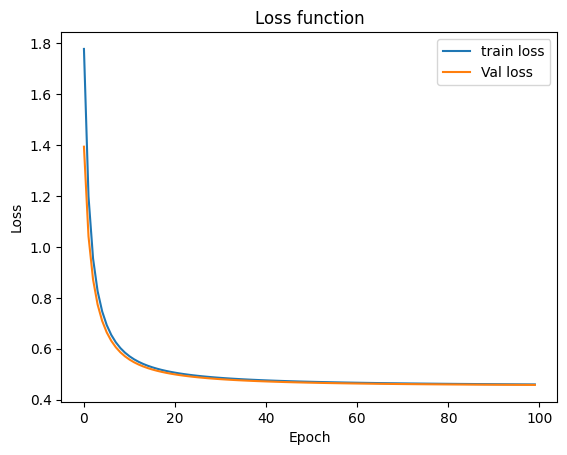

In [29]:
#tanh
model22 = MyMLP(num_input_dims=autoencoder_train_fts.shape[1], 
               num_neurons=[],
               num_classes=num_labels)
weight_adjuster2 = torch.optim.Adam(model22.parameters())
train(model22, autoencoder_train_fts, train_labels, val_features=autoencoder_dev_fts,val_labels=dev_labels,
      weight_adjuster=weight_adjuster2,
      num_epochs=100, batch_size=80,
      epoch_callback=predict_callback(actual=dev_labels.unsqueeze(1),
                                      input_fts=autoencoder_dev_fts,
                                      model=model22))

In [30]:
x_pred=model22.predict(autoencoder11(test_fts)[0])
import numpy as np

matches = [1 if a == b else 0 for a, b in zip(x_pred, test_labels)]
total_matches = sum(matches)

print(f"Accuracy: {total_matches/10000:.4f}%")

torch.Size([10000, 64])
torch.Size([10000, 10])
Accuracy: 0.8723%


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


[64]
[10]
[10] outs
64 :i o: 10
Epoch 0


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8401
Epoch loss: 0.822783
Val loss: 0.566715
Epoch 1


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8505
Epoch loss: 0.537886
Val loss: 0.504471
Epoch 2


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8545
Epoch loss: 0.500628
Val loss: 0.483988
Epoch 3


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8578
Epoch loss: 0.485759
Val loss: 0.474547
Epoch 4


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8589
Epoch loss: 0.478077
Val loss: 0.469394
Epoch 5


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8607999999999999
Epoch loss: 0.473511
Val loss: 0.466261
Epoch 6


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8623
Epoch loss: 0.470546
Val loss: 0.464209
Epoch 7


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8635
Epoch loss: 0.468502
Val loss: 0.462792
Epoch 8


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8642
Epoch loss: 0.467032
Val loss: 0.461775
Epoch 9


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8634
Epoch loss: 0.465943
Val loss: 0.461023
Epoch 10


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8635
Epoch loss: 0.465117
Val loss: 0.460456
Epoch 11


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8637
Epoch loss: 0.464478
Val loss: 0.460019
Epoch 12


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8636
Epoch loss: 0.463978
Val loss: 0.459680
Epoch 13


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8635
Epoch loss: 0.463580
Val loss: 0.459412
Epoch 14


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8635
Epoch loss: 0.463261
Val loss: 0.459200
Epoch 15


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8637999999999999
Epoch loss: 0.463002
Val loss: 0.459030
Epoch 16


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8637
Epoch loss: 0.462791
Val loss: 0.458893
Epoch 17


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8635
Epoch loss: 0.462618
Val loss: 0.458782
Epoch 18


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8633
Epoch loss: 0.462475
Val loss: 0.458693
Epoch 19


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8634
Epoch loss: 0.462357
Val loss: 0.458619
Epoch 20


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8636
Epoch loss: 0.462257
Val loss: 0.458560
Epoch 21


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8636
Epoch loss: 0.462174
Val loss: 0.458511
Epoch 22


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8639
Epoch loss: 0.462104
Val loss: 0.458470
Epoch 23


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.864
Epoch loss: 0.462045
Val loss: 0.458438
Epoch 24


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8643000000000001
Epoch loss: 0.461995
Val loss: 0.458411
Epoch 25


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8646
Epoch loss: 0.461952
Val loss: 0.458388
Epoch 26


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8646
Epoch loss: 0.461916
Val loss: 0.458370
Epoch 27


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8646999999999999
Epoch loss: 0.461885
Val loss: 0.458355
Epoch 28


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8646999999999999
Epoch loss: 0.461859
Val loss: 0.458343
Epoch 29


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8646
Epoch loss: 0.461836
Val loss: 0.458333
Epoch 30


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8646
Epoch loss: 0.461816
Val loss: 0.458326
Epoch 31


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8645
Epoch loss: 0.461799
Val loss: 0.458319
Epoch 32


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8645
Epoch loss: 0.461784
Val loss: 0.458314
Epoch 33


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8646999999999999
Epoch loss: 0.461772
Val loss: 0.458310
Epoch 34


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8646999999999999
Epoch loss: 0.461761
Val loss: 0.458307
Epoch 35


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8648
Epoch loss: 0.461751
Val loss: 0.458305
Epoch 36


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8648
Epoch loss: 0.461743
Val loss: 0.458303
Epoch 37


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8646999999999999
Epoch loss: 0.461736
Val loss: 0.458302
Epoch 38


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8648
Epoch loss: 0.461729
Val loss: 0.458301
Epoch 39


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 64])
torch.Size([10000, 10])
f1 score: 0.8649
Epoch loss: 0.461724
Val loss: 0.458300


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


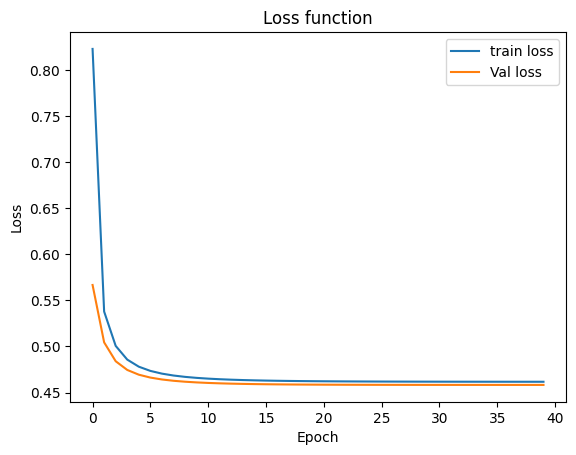

In [34]:
#changing epochs,learning rate,batch size for tanh
model2 = MyMLP(num_input_dims=autoencoder_train_fts.shape[1], 
               num_neurons=[],
               num_classes=num_labels)
weight_adjuster2 = torch.optim.Adam(model2.parameters(),lr=0.01)
train(model2, autoencoder_train_fts, train_labels, val_features=autoencoder_dev_fts,val_labels=dev_labels,
      weight_adjuster=weight_adjuster2,
      num_epochs=40, batch_size=60,
      epoch_callback=predict_callback(actual=dev_labels,
                                      input_fts=autoencoder_dev_fts,
                                      model=model2))

In [35]:
x_pred=model2.predict(autoencoder1(test_fts)[0])
import numpy as np

matches = [1 if a == b else 0 for a, b in zip(x_pred, test_labels)]
total_matches = sum(matches)

print(f"Accuracy: {total_matches/10000:.4f}%")

torch.Size([10000, 64])
torch.Size([10000, 10])
Accuracy: 0.0958%


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


In [36]:
#Reduced dimension returns encoded  Encoder 256
class Autoencoder3(nn.Module):
    def __init__(self, num_input_dims, num_hidden_dims, act_fn=nn.Sigmoid):
        super(Autoencoder3, self).__init__()
        self.encoder = nn.Linear(num_input_dims, num_hidden_dims)
        self.decoder = nn.Linear(num_hidden_dims, num_input_dims)
        self.activation = act_fn()

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = self.activation(encoded)
        decoded = self.decoder(encoded)
        decoded = self.activation(decoded)
        return  encoded,decoded
        #return x

In [37]:
autoencoder3 = Autoencoder3(784,256) # intentionally not providing arguments: You fill in!
autoencoder_adjuster3 = torch.optim.Adam(autoencoder3.parameters())
with torch.no_grad():
  autoencoder_train_fts = autoencoder3(train_fts)[0]
  autoencoder_dev_fts = autoencoder3(dev_fts)[0]
print(autoencoder_train_fts.shape[1])

256


[256]
[10]
[10] outs
256 :i o: 10
Epoch 0


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.4099
Epoch loss: 2.174300
Val loss: 2.041793
Epoch 1


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.547
Epoch loss: 1.921490
Val loss: 1.812129
Epoch 2


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6374
Epoch loss: 1.714070
Val loss: 1.624069
Epoch 3


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6926
Epoch loss: 1.544416
Val loss: 1.470106
Epoch 4


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7292
Epoch loss: 1.405343
Val loss: 1.343456
Epoch 5


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7514
Epoch loss: 1.290666
Val loss: 1.238527
Epoch 6


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7704
Epoch loss: 1.195384
Val loss: 1.150880
Epoch 7


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7844
Epoch loss: 1.115555
Val loss: 1.077041
Epoch 8


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7948
Epoch loss: 1.048098
Val loss: 1.014304
Epoch 9


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8035
Epoch loss: 0.990610
Val loss: 0.960556
Epoch 10


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8097999999999999
Epoch loss: 0.941211
Val loss: 0.914140
Epoch 11


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8145
Epoch loss: 0.898427
Val loss: 0.873752
Epoch 12


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8198
Epoch loss: 0.861093
Val loss: 0.838358
Epoch 13


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8244
Epoch loss: 0.828286
Val loss: 0.807134
Epoch 14


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8285
Epoch loss: 0.799267
Val loss: 0.779415
Epoch 15


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8327000000000001
Epoch loss: 0.773442
Val loss: 0.754667
Epoch 16


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8364
Epoch loss: 0.750329
Val loss: 0.732451
Epoch 17


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8389000000000001
Epoch loss: 0.729534
Val loss: 0.712410
Epoch 18


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.842
Epoch loss: 0.710734
Val loss: 0.694247
Epoch 19


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.844
Epoch loss: 0.693661
Val loss: 0.677714
Epoch 20


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8457
Epoch loss: 0.678091
Val loss: 0.662606
Epoch 21


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8479
Epoch loss: 0.663836
Val loss: 0.648749
Epoch 22


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8497
Epoch loss: 0.650739
Val loss: 0.635994
Epoch 23


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8515
Epoch loss: 0.638664
Val loss: 0.624216
Epoch 24


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8531
Epoch loss: 0.627497
Val loss: 0.613307
Epoch 25


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8550999999999999
Epoch loss: 0.617138
Val loss: 0.603175
Epoch 26


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8557999999999999
Epoch loss: 0.607504
Val loss: 0.593738
Epoch 27


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8571000000000001
Epoch loss: 0.598520
Val loss: 0.584928
Epoch 28


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8586
Epoch loss: 0.590121
Val loss: 0.576684
Epoch 29


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8596
Epoch loss: 0.582252
Val loss: 0.568951
Epoch 30


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8614
Epoch loss: 0.574864
Val loss: 0.561684
Epoch 31


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8626
Epoch loss: 0.567912
Val loss: 0.554841
Epoch 32


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8632
Epoch loss: 0.561359
Val loss: 0.548384
Epoch 33


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8643000000000001
Epoch loss: 0.555171
Val loss: 0.542283
Epoch 34


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8651
Epoch loss: 0.549316
Val loss: 0.536506
Epoch 35


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8657
Epoch loss: 0.543769
Val loss: 0.531029
Epoch 36


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8663
Epoch loss: 0.538505
Val loss: 0.525829
Epoch 37


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8671999999999999
Epoch loss: 0.533501
Val loss: 0.520884
Epoch 38


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8682
Epoch loss: 0.528739
Val loss: 0.516174
Epoch 39


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8687
Epoch loss: 0.524201
Val loss: 0.511685
Epoch 40


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8691000000000001
Epoch loss: 0.519871
Val loss: 0.507399
Epoch 41


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8692
Epoch loss: 0.515734
Val loss: 0.503303
Epoch 42


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8697999999999999
Epoch loss: 0.511776
Val loss: 0.499384
Epoch 43


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8705
Epoch loss: 0.507987
Val loss: 0.495631
Epoch 44


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8713999999999998
Epoch loss: 0.504355
Val loss: 0.492032
Epoch 45


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8721
Epoch loss: 0.500871
Val loss: 0.488578
Epoch 46


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8726
Epoch loss: 0.497523
Val loss: 0.485260
Epoch 47


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8734
Epoch loss: 0.494306
Val loss: 0.482070
Epoch 48


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8739
Epoch loss: 0.491210
Val loss: 0.479000
Epoch 49


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8745
Epoch loss: 0.488228
Val loss: 0.476044
Epoch 50


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8752
Epoch loss: 0.485355
Val loss: 0.473194
Epoch 51


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8759999999999999
Epoch loss: 0.482583
Val loss: 0.470446
Epoch 52


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8767
Epoch loss: 0.479907
Val loss: 0.467793
Epoch 53


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8774
Epoch loss: 0.477323
Val loss: 0.465230
Epoch 54


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.878
Epoch loss: 0.474824
Val loss: 0.462752
Epoch 55


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8784
Epoch loss: 0.472407
Val loss: 0.460356
Epoch 56


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8787
Epoch loss: 0.470068
Val loss: 0.458037
Epoch 57


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.879
Epoch loss: 0.467802
Val loss: 0.455791
Epoch 58


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8798
Epoch loss: 0.465606
Val loss: 0.453615
Epoch 59


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8802
Epoch loss: 0.463476
Val loss: 0.451504
Epoch 60


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8808
Epoch loss: 0.461410
Val loss: 0.449457
Epoch 61


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8812
Epoch loss: 0.459404
Val loss: 0.447470
Epoch 62


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8812
Epoch loss: 0.457455
Val loss: 0.445541
Epoch 63


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8814
Epoch loss: 0.455562
Val loss: 0.443666
Epoch 64


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8817999999999999
Epoch loss: 0.453720
Val loss: 0.441844
Epoch 65


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.882
Epoch loss: 0.451929
Val loss: 0.440071
Epoch 66


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8825
Epoch loss: 0.450186
Val loss: 0.438347
Epoch 67


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8829
Epoch loss: 0.448489
Val loss: 0.436669
Epoch 68


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8834000000000001
Epoch loss: 0.446835
Val loss: 0.435034
Epoch 69


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.884
Epoch loss: 0.445224
Val loss: 0.433442
Epoch 70


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8839
Epoch loss: 0.443653
Val loss: 0.431890
Epoch 71


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8842
Epoch loss: 0.442121
Val loss: 0.430378
Epoch 72


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8844
Epoch loss: 0.440627
Val loss: 0.428902
Epoch 73


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8849
Epoch loss: 0.439168
Val loss: 0.427463
Epoch 74


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8849
Epoch loss: 0.437743
Val loss: 0.426058
Epoch 75


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8856
Epoch loss: 0.436351
Val loss: 0.424686
Epoch 76


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8856
Epoch loss: 0.434992
Val loss: 0.423346
Epoch 77


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8858
Epoch loss: 0.433663
Val loss: 0.422038
Epoch 78


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8858
Epoch loss: 0.432364
Val loss: 0.420758
Epoch 79


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.886
Epoch loss: 0.431093
Val loss: 0.419508
Epoch 80


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8859000000000001
Epoch loss: 0.429849
Val loss: 0.418285
Epoch 81


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8861
Epoch loss: 0.428632
Val loss: 0.417089
Epoch 82


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8864
Epoch loss: 0.427441
Val loss: 0.415919
Epoch 83


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8865
Epoch loss: 0.426275
Val loss: 0.414773
Epoch 84


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8869
Epoch loss: 0.425132
Val loss: 0.413652
Epoch 85


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.887
Epoch loss: 0.424013
Val loss: 0.412554
Epoch 86


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8872
Epoch loss: 0.422916
Val loss: 0.411478
Epoch 87


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8875
Epoch loss: 0.421840
Val loss: 0.410424
Epoch 88


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8878000000000001
Epoch loss: 0.420786
Val loss: 0.409391
Epoch 89


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.888
Epoch loss: 0.419751
Val loss: 0.408379


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


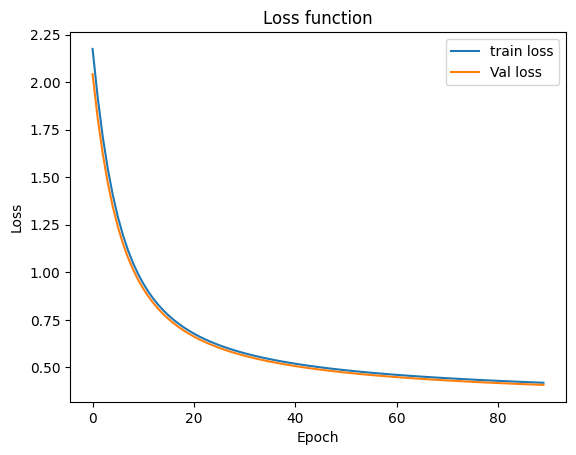

In [38]:
#lr=0.001,epoch=40,batch=60
model4 = MyMLP(num_input_dims=autoencoder_train_fts.shape[1], 
               num_neurons=[],
               num_classes=num_labels)
weight_adjuster2 = torch.optim.Adam(model4.parameters(),lr=0.001)
train(model4, autoencoder_train_fts, train_labels, val_features=autoencoder_dev_fts,val_labels=dev_labels,
      weight_adjuster=weight_adjuster2,
      num_epochs=90, batch_size=60,
      epoch_callback=predict_callback(actual=dev_labels,
                                      input_fts=autoencoder_dev_fts,
                                      model=model4))

In [39]:
x_pred=model4.predict(autoencoder3(test_fts)[0])
import numpy as np

matches = [1 if a == b else 0 for a, b in zip(x_pred, test_labels)]
total_matches = sum(matches)

print(f"Accuracy: {total_matches/10000:.4f}%")

torch.Size([10000, 256])
torch.Size([10000, 10])
Accuracy: 0.8881%


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


In [40]:
autoencoder3 = Autoencoder3(784,256,nn.Softmax ) # intentionally not providing arguments: You fill in!
autoencoder_adjuster3 = torch.optim.Adam(autoencoder3.parameters())
with torch.no_grad():
  autoencoder_train_fts = autoencoder3(train_fts)[0]
  autoencoder_dev_fts = autoencoder3(dev_fts)[0]

<ipython-input-36-fbe069601860>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  encoded = self.activation(encoded)
<ipython-input-36-fbe069601860>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  decoded = self.activation(decoded)


[256]
[10]
[10] outs
256 :i o: 10
Epoch 0


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.1147
Epoch loss: 2.294332
Val loss: 2.286205
Epoch 1


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.135
Epoch loss: 2.279251
Val loss: 2.271292
Epoch 2


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.2255
Epoch loss: 2.264465
Val loss: 2.256500
Epoch 3


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.3099
Epoch loss: 2.249799
Val loss: 2.241828
Epoch 4


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.3857
Epoch loss: 2.235251
Val loss: 2.227273
Epoch 5


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.4415
Epoch loss: 2.220821
Val loss: 2.212837
Epoch 6


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.4842
Epoch loss: 2.206507
Val loss: 2.198518
Epoch 7


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.5185
Epoch loss: 2.192312
Val loss: 2.184317
Epoch 8


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.5432
Epoch loss: 2.178233
Val loss: 2.170233
Epoch 9


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.5623
Epoch loss: 2.164271
Val loss: 2.156268
Epoch 10


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.5788
Epoch loss: 2.150426
Val loss: 2.142420
Epoch 11


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.5911
Epoch loss: 2.136698
Val loss: 2.128688
Epoch 12


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6027
Epoch loss: 2.123087
Val loss: 2.115074
Epoch 13


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6124
Epoch loss: 2.109592
Val loss: 2.101577
Epoch 14


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6211
Epoch loss: 2.096213
Val loss: 2.088197
Epoch 15


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.628
Epoch loss: 2.082950
Val loss: 2.074932
Epoch 16


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6336
Epoch loss: 2.069803
Val loss: 2.061785
Epoch 17


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6397
Epoch loss: 2.056772
Val loss: 2.048753
Epoch 18


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.644
Epoch loss: 2.043855
Val loss: 2.035836
Epoch 19


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6483
Epoch loss: 2.031054
Val loss: 2.023036
Epoch 20


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6522
Epoch loss: 2.018368
Val loss: 2.010350
Epoch 21


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6565
Epoch loss: 2.005796
Val loss: 1.997779
Epoch 22


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6598
Epoch loss: 1.993338
Val loss: 1.985323
Epoch 23


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.663
Epoch loss: 1.980994
Val loss: 1.972981
Epoch 24


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6661
Epoch loss: 1.968763
Val loss: 1.960752
Epoch 25


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6697
Epoch loss: 1.956646
Val loss: 1.948637
Epoch 26


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6731
Epoch loss: 1.944641
Val loss: 1.936634
Epoch 27


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6756
Epoch loss: 1.932748
Val loss: 1.924745
Epoch 28


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6776
Epoch loss: 1.920967
Val loss: 1.912967
Epoch 29


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6799
Epoch loss: 1.909297
Val loss: 1.901301
Epoch 30


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.682
Epoch loss: 1.897738
Val loss: 1.889746
Epoch 31


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6836
Epoch loss: 1.886289
Val loss: 1.878301
Epoch 32


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.685
Epoch loss: 1.874951
Val loss: 1.866967
Epoch 33


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6865
Epoch loss: 1.863721
Val loss: 1.855742
Epoch 34


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.689
Epoch loss: 1.852601
Val loss: 1.844626
Epoch 35


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6911
Epoch loss: 1.841589
Val loss: 1.833619
Epoch 36


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6926
Epoch loss: 1.830685
Val loss: 1.822720
Epoch 37


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6943
Epoch loss: 1.819887
Val loss: 1.811928
Epoch 38


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6963
Epoch loss: 1.809197
Val loss: 1.801242
Epoch 39


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.6977
Epoch loss: 1.798612
Val loss: 1.790663
Epoch 40


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7005
Epoch loss: 1.788132
Val loss: 1.780189
Epoch 41


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7026
Epoch loss: 1.777758
Val loss: 1.769820
Epoch 42


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7045
Epoch loss: 1.767487
Val loss: 1.759555
Epoch 43


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7061
Epoch loss: 1.757320
Val loss: 1.749394
Epoch 44


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7076
Epoch loss: 1.747255
Val loss: 1.739335
Epoch 45


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7093
Epoch loss: 1.737293
Val loss: 1.729378
Epoch 46


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7114
Epoch loss: 1.727431
Val loss: 1.719523
Epoch 47


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7126
Epoch loss: 1.717671
Val loss: 1.709769
Epoch 48


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.714
Epoch loss: 1.708010
Val loss: 1.700114
Epoch 49


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7153
Epoch loss: 1.698448
Val loss: 1.690558
Epoch 50


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7162
Epoch loss: 1.688985
Val loss: 1.681101
Epoch 51


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7172
Epoch loss: 1.679619
Val loss: 1.671741
Epoch 52


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7186
Epoch loss: 1.670350
Val loss: 1.662479
Epoch 53


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7201
Epoch loss: 1.661177
Val loss: 1.653312
Epoch 54


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7219
Epoch loss: 1.652100
Val loss: 1.644240
Epoch 55


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7233
Epoch loss: 1.643117
Val loss: 1.635263
Epoch 56


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7246
Epoch loss: 1.634228
Val loss: 1.626380
Epoch 57


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7257
Epoch loss: 1.625431
Val loss: 1.617590
Epoch 58


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7267
Epoch loss: 1.616727
Val loss: 1.608891
Epoch 59


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7279
Epoch loss: 1.608114
Val loss: 1.600284
Epoch 60


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7283999999999999
Epoch loss: 1.599592
Val loss: 1.591767
Epoch 61


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7296
Epoch loss: 1.591159
Val loss: 1.583340
Epoch 62


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7305
Epoch loss: 1.582815
Val loss: 1.575001
Epoch 63


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7315
Epoch loss: 1.574559
Val loss: 1.566751
Epoch 64


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7333999999999999
Epoch loss: 1.566390
Val loss: 1.558587
Epoch 65


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7346
Epoch loss: 1.558307
Val loss: 1.550510
Epoch 66


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7354000000000002
Epoch loss: 1.550310
Val loss: 1.542518
Epoch 67


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7367000000000001
Epoch loss: 1.542397
Val loss: 1.534610
Epoch 68


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7372
Epoch loss: 1.534569
Val loss: 1.526787
Epoch 69


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7384
Epoch loss: 1.526823
Val loss: 1.519046
Epoch 70


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7396
Epoch loss: 1.519159
Val loss: 1.511387
Epoch 71


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7408
Epoch loss: 1.511577
Val loss: 1.503809
Epoch 72


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7417
Epoch loss: 1.504075
Val loss: 1.496311
Epoch 73


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7426
Epoch loss: 1.496653
Val loss: 1.488893
Epoch 74


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7434
Epoch loss: 1.489309
Val loss: 1.481553
Epoch 75


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7441000000000001
Epoch loss: 1.482043
Val loss: 1.474291
Epoch 76


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7451
Epoch loss: 1.474854
Val loss: 1.467106
Epoch 77


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7465
Epoch loss: 1.467741
Val loss: 1.459997
Epoch 78


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7467
Epoch loss: 1.460704
Val loss: 1.452964
Epoch 79


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.7472
Epoch loss: 1.453742
Val loss: 1.446004


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


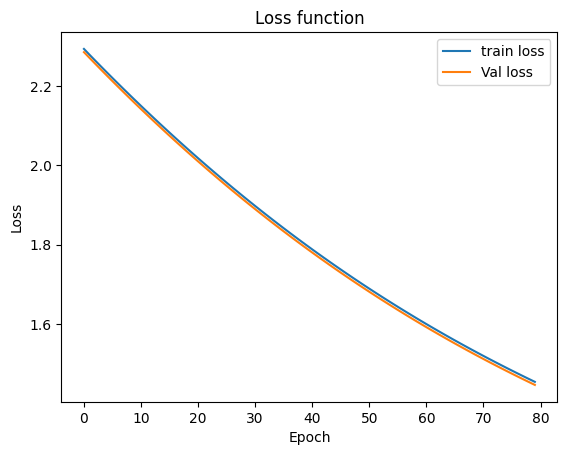

In [41]:
#lr=0.001,epoch=50,batch=80
model5 = MyMLP(num_input_dims=autoencoder_train_fts.shape[1], 
               num_neurons=[],
               num_classes=num_labels)
weight_adjuster2 = torch.optim.Adam(model5.parameters(),lr=0.001)
train(model5, autoencoder_train_fts, train_labels, val_features=autoencoder_dev_fts,val_labels=dev_labels,
      weight_adjuster=weight_adjuster2,
      num_epochs=80, batch_size=25,
      epoch_callback=predict_callback(actual=dev_labels,
                                      input_fts=autoencoder_dev_fts,
                                      model=model5))

In [42]:
x_pred=model5.predict(autoencoder3(test_fts)[0])
import numpy as np

matches = [1 if a == b else 0 for a, b in zip(x_pred, test_labels)]
total_matches = sum(matches)

print(f"Accuracy: {total_matches/10000:.4f}%")

<ipython-input-36-fbe069601860>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  encoded = self.activation(encoded)
<ipython-input-36-fbe069601860>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  decoded = self.activation(decoded)
<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
Accuracy: 0.7531%


[256]
[10]
[10] outs
256 :i o: 10
Epoch 0


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.857
Epoch loss: 1.003365
Val loss: 0.596847
Epoch 1


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8744
Epoch loss: 0.526099
Val loss: 0.463103
Epoch 2


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8841
Epoch loss: 0.443067
Val loss: 0.411914
Epoch 3


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8895
Epoch loss: 0.404720
Val loss: 0.383945
Epoch 4


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8937
Epoch loss: 0.381952
Val loss: 0.366150
Epoch 5


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8977
Epoch loss: 0.366687
Val loss: 0.353803
Epoch 6


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9004
Epoch loss: 0.355661
Val loss: 0.344726
Epoch 7


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9027
Epoch loss: 0.347275
Val loss: 0.337766
Epoch 8


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9037
Epoch loss: 0.340650
Val loss: 0.332256
Epoch 9


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9048
Epoch loss: 0.335259
Val loss: 0.327782
Epoch 10


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9056
Epoch loss: 0.330768
Val loss: 0.324076
Epoch 11


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9064999999999999
Epoch loss: 0.326957
Val loss: 0.320954
Epoch 12


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.907
Epoch loss: 0.323670
Val loss: 0.318287
Epoch 13


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9078
Epoch loss: 0.320799
Val loss: 0.315982
Epoch 14


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9086
Epoch loss: 0.318261
Val loss: 0.313969
Epoch 15


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9085
Epoch loss: 0.315997
Val loss: 0.312196
Epoch 16


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9087
Epoch loss: 0.313960
Val loss: 0.310622
Epoch 17


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9092
Epoch loss: 0.312114
Val loss: 0.309215
Epoch 18


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9097
Epoch loss: 0.310430
Val loss: 0.307950
Epoch 19


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9101
Epoch loss: 0.308885
Val loss: 0.306805
Epoch 20


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9103999999999999
Epoch loss: 0.307461
Val loss: 0.305765
Epoch 21


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9111000000000001
Epoch loss: 0.306142
Val loss: 0.304815
Epoch 22


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9114
Epoch loss: 0.304915
Val loss: 0.303944
Epoch 23


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9118
Epoch loss: 0.303770
Val loss: 0.303142
Epoch 24


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9119
Epoch loss: 0.302698
Val loss: 0.302401
Epoch 25


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.912
Epoch loss: 0.301690
Val loss: 0.301715
Epoch 26


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9123
Epoch loss: 0.300741
Val loss: 0.301077
Epoch 27


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9127
Epoch loss: 0.299845
Val loss: 0.300483
Epoch 28


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9128
Epoch loss: 0.298996
Val loss: 0.299927
Epoch 29


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9133
Epoch loss: 0.298191
Val loss: 0.299407
Epoch 30


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9130000000000001
Epoch loss: 0.297426
Val loss: 0.298918
Epoch 31


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9131
Epoch loss: 0.296698
Val loss: 0.298458
Epoch 32


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9133
Epoch loss: 0.296003
Val loss: 0.298025
Epoch 33


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9135
Epoch loss: 0.295339
Val loss: 0.297616
Epoch 34


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.914
Epoch loss: 0.294703
Val loss: 0.297229
Epoch 35


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9141
Epoch loss: 0.294094
Val loss: 0.296862
Epoch 36


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9145
Epoch loss: 0.293510
Val loss: 0.296514
Epoch 37


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.915
Epoch loss: 0.292949
Val loss: 0.296183
Epoch 38


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9149
Epoch loss: 0.292410
Val loss: 0.295868
Epoch 39


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9151
Epoch loss: 0.291890
Val loss: 0.295568
Epoch 40


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9151
Epoch loss: 0.291389
Val loss: 0.295281
Epoch 41


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9151
Epoch loss: 0.290906
Val loss: 0.295008
Epoch 42


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9148
Epoch loss: 0.290440
Val loss: 0.294746
Epoch 43


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9147
Epoch loss: 0.289989
Val loss: 0.294496
Epoch 44


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.915
Epoch loss: 0.289553
Val loss: 0.294256
Epoch 45


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9151
Epoch loss: 0.289131
Val loss: 0.294026
Epoch 46


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9154
Epoch loss: 0.288722
Val loss: 0.293805
Epoch 47


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9154
Epoch loss: 0.288326
Val loss: 0.293593
Epoch 48


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9155
Epoch loss: 0.287942
Val loss: 0.293389
Epoch 49


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9157
Epoch loss: 0.287568
Val loss: 0.293192
Epoch 50


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9157
Epoch loss: 0.287206
Val loss: 0.293003
Epoch 51


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9159
Epoch loss: 0.286853
Val loss: 0.292821
Epoch 52


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.916
Epoch loss: 0.286511
Val loss: 0.292646
Epoch 53


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.916
Epoch loss: 0.286177
Val loss: 0.292476
Epoch 54


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9162
Epoch loss: 0.285853
Val loss: 0.292313
Epoch 55


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9163
Epoch loss: 0.285536
Val loss: 0.292155
Epoch 56


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9163
Epoch loss: 0.285228
Val loss: 0.292002
Epoch 57


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9163
Epoch loss: 0.284928
Val loss: 0.291854
Epoch 58


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9163
Epoch loss: 0.284634
Val loss: 0.291711
Epoch 59


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9162
Epoch loss: 0.284348
Val loss: 0.291573
Epoch 60


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9165
Epoch loss: 0.284069
Val loss: 0.291439
Epoch 61


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9166
Epoch loss: 0.283796
Val loss: 0.291309
Epoch 62


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9166
Epoch loss: 0.283530
Val loss: 0.291183
Epoch 63


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9167
Epoch loss: 0.283269
Val loss: 0.291061
Epoch 64


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9168
Epoch loss: 0.283014
Val loss: 0.290943
Epoch 65


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9169
Epoch loss: 0.282765
Val loss: 0.290828
Epoch 66


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9171000000000001
Epoch loss: 0.282521
Val loss: 0.290716
Epoch 67


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9171999999999999
Epoch loss: 0.282282
Val loss: 0.290608
Epoch 68


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.917
Epoch loss: 0.282048
Val loss: 0.290503
Epoch 69


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9171000000000001
Epoch loss: 0.281819
Val loss: 0.290401
Epoch 70


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.917
Epoch loss: 0.281595
Val loss: 0.290301
Epoch 71


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9169
Epoch loss: 0.281375
Val loss: 0.290205
Epoch 72


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9171000000000001
Epoch loss: 0.281159
Val loss: 0.290111
Epoch 73


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.917
Epoch loss: 0.280948
Val loss: 0.290019
Epoch 74


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9169
Epoch loss: 0.280740
Val loss: 0.289930
Epoch 75


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9169
Epoch loss: 0.280537
Val loss: 0.289843
Epoch 76


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9169
Epoch loss: 0.280337
Val loss: 0.289759
Epoch 77


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.917
Epoch loss: 0.280141
Val loss: 0.289677
Epoch 78


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9171999999999999
Epoch loss: 0.279948
Val loss: 0.289597
Epoch 79


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9174
Epoch loss: 0.279759
Val loss: 0.289519
Epoch 80


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9173000000000001
Epoch loss: 0.279573
Val loss: 0.289443
Epoch 81


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9173000000000001
Epoch loss: 0.279390
Val loss: 0.289368
Epoch 82


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9171999999999999
Epoch loss: 0.279211
Val loss: 0.289296
Epoch 83


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9173000000000001
Epoch loss: 0.279034
Val loss: 0.289225
Epoch 84


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9173000000000001
Epoch loss: 0.278861
Val loss: 0.289157
Epoch 85


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9174
Epoch loss: 0.278690
Val loss: 0.289089
Epoch 86


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9174
Epoch loss: 0.278522
Val loss: 0.289024
Epoch 87


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9174
Epoch loss: 0.278357
Val loss: 0.288960
Epoch 88


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9174
Epoch loss: 0.278194
Val loss: 0.288897
Epoch 89


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9171999999999999
Epoch loss: 0.278034
Val loss: 0.288836


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


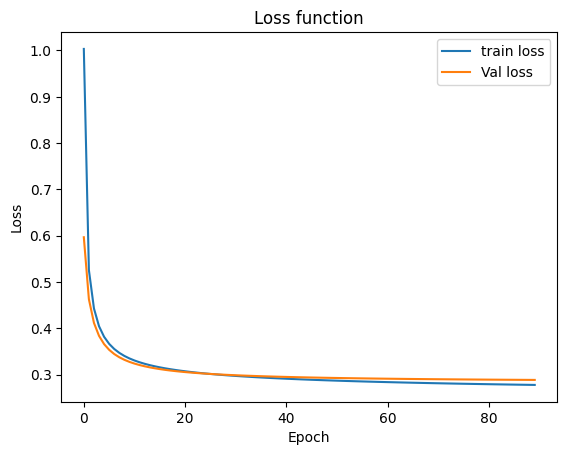

In [43]:
autoencoder3 = Autoencoder3(784,256,nn.Tanh ) # intentionally not providing arguments: You fill in!
autoencoder_adjuster3 = torch.optim.Adam(autoencoder3.parameters())
with torch.no_grad():
  autoencoder_train_fts = autoencoder3(train_fts)[0]
  autoencoder_dev_fts = autoencoder3(dev_fts)[0]



model4 = MyMLP(num_input_dims=autoencoder_train_fts.shape[1], 
               num_neurons=[],
               num_classes=num_labels)
weight_adjuster2 = torch.optim.Adam(model4.parameters(),lr=0.001)
train(model4, autoencoder_train_fts, train_labels, val_features=autoencoder_dev_fts,val_labels=dev_labels,
      weight_adjuster=weight_adjuster2,
      num_epochs=90, batch_size=60,
      epoch_callback=predict_callback(actual=dev_labels,
                                      input_fts=autoencoder_dev_fts,
                                      model=model4))

In [44]:
x_pred=model4.predict(autoencoder3(test_fts)[0])
import numpy as np

matches = [1 if a == b else 0 for a, b in zip(x_pred, test_labels)]
total_matches = sum(matches)

print(f"Accuracy: {total_matches/10000:.4f}%")

<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
Accuracy: 0.9190%


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LoR = LogisticRegression(random_state=42)
LoR.fit(train_fts, train_labels)

y_pred = LoR.predict(test_fts)
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9256


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3.

In [124]:
def train(model, data_features, data_labels, weight_adjuster,val_features, val_labels,
          loss_fn = nn.CrossEntropyLoss(),loss_fn2=nn.BCELoss(),
          batch_size=100,
          num_epochs=5,
          epoch_callback=None):
  #loss_fn=nn.BCELoss();
  loss_values = []
  val_loss_values = []
  #data_labels = torch.nn.functional.one_hot(data_labels, num_classes=10).float()
  for epoch in range(num_epochs):
    print("Epoch %d" % epoch)
    epoch_loss = 0.0
    batch_start = 0
    batch_end = min(batch_size, data_features.shape[0])
    num_batches = int(numpy.ceil(data_features.shape[0] / batch_size))
    for batch_idx, batch in enumerate(range(num_batches)):
      batch = data_features[batch_start:batch_end,:]
      weight_adjuster.zero_grad()
      #print(batch.shape,":batch")
      logits = model(batch)

      #print("logits",logits.shape,"logits[0]:",logits[0].shape)
      labels = data_labels[batch_start:batch_end]
      import torch.nn.functional as F

      labels_one_hot = F.one_hot(labels, num_classes=10)
      loss1 = loss_fn2(input=logits[1], target=labels_one_hot.float())
      #print(len(logits[0]),"logits[0]")
      #print(len(logits[1]),"logits[1]")
      #loss1=loss_fn2(input=logits,target=labels)
      #logits_sigmoid = torch.sigmoid(_)
      #loss1 = loss_fn2(input=logits_sigmoid, target=data_labels[batch_start:batch_end,:])#labels.float())
      loss = loss_fn(input=logits[0],#.float(),
                    target=labels)
      loss=loss+loss1
      #print("labels.shape")
      loss.backward()
      weight_adjuster.step()

      epoch_loss += loss.item()

      batch_start = batch_end
      batch_end = batch_end+batch_size
      batch_end = min(batch_end, data_features.shape[0])

    if epoch_callback is not None:
      epoch_callback()

    epoch_loss /= num_batches # average the epoch loss over all batches
    loss_values.append(epoch_loss)
    print("Epoch loss: %f" % epoch_loss)

    with torch.no_grad():
      val_logits = model(val_features)
      val_loss = loss_fn(input=val_logits[0], target=val_labels)
      val_loss_values.append(val_loss.item())
      print("Val loss: %f" % val_loss.item())

  # plot the loss values
  plt.plot(loss_values,label='train loss')
  plt.plot(val_loss_values, label='Val loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss function')
  plt.legend()
  plt.show()

In [126]:
class Autoencoder_3(nn.Module):
    def __init__(self, num_input_dims, num_hidden_dims, act_fn=nn.Sigmoid):
        super(Autoencoder_3, self).__init__()
        self.encoder = nn.Linear(num_input_dims, num_hidden_dims)
        self.decoder = nn.Linear(num_hidden_dims, num_input_dims)
        self.activation = act_fn()

    def forward(self, x):
        #x = self.encoder(x)
        #x = self.activation(x)
        encoded = self.encoder(x)
        encoded = self.activation(encoded)
        decoded = self.decoder(encoded)
        decoded = self.activation(decoded)
        return  encoded,decoded

256 au
[256]
[10]
[10] outs
256 :i o: 10
Epoch 0


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8409
Epoch loss: 1.370155
Val loss: 0.721099
Epoch 1


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8686
Epoch loss: 0.716115
Val loss: 0.530772
Epoch 2


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8799
Epoch loss: 0.579515
Val loss: 0.458480
Epoch 3


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8871
Epoch loss: 0.517102
Val loss: 0.419618
Epoch 4


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8903
Epoch loss: 0.480620
Val loss: 0.395203
Epoch 5


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8932
Epoch loss: 0.456511
Val loss: 0.378441
Epoch 6


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8952000000000001
Epoch loss: 0.439335
Val loss: 0.366245
Epoch 7


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.8982
Epoch loss: 0.426449
Val loss: 0.356994
Epoch 8


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9007
Epoch loss: 0.416404
Val loss: 0.349747
Epoch 9


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9025
Epoch loss: 0.408335
Val loss: 0.343922
Epoch 10


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9035
Epoch loss: 0.401696
Val loss: 0.339139
Epoch 11


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.905
Epoch loss: 0.396120
Val loss: 0.335139
Epoch 12


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9057
Epoch loss: 0.391359
Val loss: 0.331743
Epoch 13


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9066
Epoch loss: 0.387235
Val loss: 0.328820
Epoch 14


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.907
Epoch loss: 0.383617
Val loss: 0.326276
Epoch 15


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9074
Epoch loss: 0.380409
Val loss: 0.324039
Epoch 16


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9076999999999998
Epoch loss: 0.377540
Val loss: 0.322055
Epoch 17


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9081999999999999
Epoch loss: 0.374953
Val loss: 0.320283
Epoch 18


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9092
Epoch loss: 0.372603
Val loss: 0.318687
Epoch 19


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9094
Epoch loss: 0.370456
Val loss: 0.317243
Epoch 20


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9102000000000001
Epoch loss: 0.368483
Val loss: 0.315929
Epoch 21


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9113
Epoch loss: 0.366662
Val loss: 0.314728
Epoch 22


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9118
Epoch loss: 0.364973
Val loss: 0.313624
Epoch 23


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9123
Epoch loss: 0.363401
Val loss: 0.312607
Epoch 24


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9125
Epoch loss: 0.361933
Val loss: 0.311666
Epoch 25


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9127
Epoch loss: 0.360557
Val loss: 0.310792
Epoch 26


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9127
Epoch loss: 0.359264
Val loss: 0.309979
Epoch 27


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9131
Epoch loss: 0.358045
Val loss: 0.309220
Epoch 28


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9134
Epoch loss: 0.356894
Val loss: 0.308509
Epoch 29


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9138
Epoch loss: 0.355804
Val loss: 0.307842
Epoch 30


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9141
Epoch loss: 0.354769
Val loss: 0.307216
Epoch 31


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9139
Epoch loss: 0.353786
Val loss: 0.306625
Epoch 32


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9141
Epoch loss: 0.352850
Val loss: 0.306067
Epoch 33


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9141
Epoch loss: 0.351957
Val loss: 0.305540
Epoch 34


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9143
Epoch loss: 0.351104
Val loss: 0.305041
Epoch 35


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9143
Epoch loss: 0.350288
Val loss: 0.304567
Epoch 36


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.914
Epoch loss: 0.349506
Val loss: 0.304117
Epoch 37


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.914
Epoch loss: 0.348755
Val loss: 0.303688
Epoch 38


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9141
Epoch loss: 0.348035
Val loss: 0.303280
Epoch 39


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9141
Epoch loss: 0.347342
Val loss: 0.302891
Epoch 40


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9146
Epoch loss: 0.346674
Val loss: 0.302519
Epoch 41


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9146
Epoch loss: 0.346032
Val loss: 0.302164
Epoch 42


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9145
Epoch loss: 0.345412
Val loss: 0.301823
Epoch 43


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9145
Epoch loss: 0.344813
Val loss: 0.301497
Epoch 44


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9145
Epoch loss: 0.344234
Val loss: 0.301184
Epoch 45


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9146
Epoch loss: 0.343675
Val loss: 0.300884
Epoch 46


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9147
Epoch loss: 0.343133
Val loss: 0.300595
Epoch 47


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9149
Epoch loss: 0.342609
Val loss: 0.300318
Epoch 48


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9154
Epoch loss: 0.342100
Val loss: 0.300051
Epoch 49


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9153
Epoch loss: 0.341607
Val loss: 0.299794
Epoch 50


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9153
Epoch loss: 0.341128
Val loss: 0.299546
Epoch 51


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9154
Epoch loss: 0.340663
Val loss: 0.299306
Epoch 52


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9154
Epoch loss: 0.340211
Val loss: 0.299076
Epoch 53


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9154
Epoch loss: 0.339772
Val loss: 0.298853
Epoch 54


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9154
Epoch loss: 0.339344
Val loss: 0.298637
Epoch 55


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9156
Epoch loss: 0.338928
Val loss: 0.298429
Epoch 56


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9156
Epoch loss: 0.338522
Val loss: 0.298227
Epoch 57


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9158
Epoch loss: 0.338127
Val loss: 0.298032
Epoch 58


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9158
Epoch loss: 0.337742
Val loss: 0.297843
Epoch 59


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9156
Epoch loss: 0.337366
Val loss: 0.297660
Epoch 60


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9158
Epoch loss: 0.336999
Val loss: 0.297483
Epoch 61


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9163
Epoch loss: 0.336641
Val loss: 0.297310
Epoch 62


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9162
Epoch loss: 0.336292
Val loss: 0.297143
Epoch 63


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9161
Epoch loss: 0.335950
Val loss: 0.296981
Epoch 64


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9161
Epoch loss: 0.335616
Val loss: 0.296823
Epoch 65


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9162
Epoch loss: 0.335289
Val loss: 0.296670
Epoch 66


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9163
Epoch loss: 0.334970
Val loss: 0.296522
Epoch 67


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9165
Epoch loss: 0.334657
Val loss: 0.296377
Epoch 68


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9166
Epoch loss: 0.334352
Val loss: 0.296236
Epoch 69


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9165
Epoch loss: 0.334052
Val loss: 0.296099
Epoch 70


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9163
Epoch loss: 0.333759
Val loss: 0.295966
Epoch 71


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9162
Epoch loss: 0.333471
Val loss: 0.295836
Epoch 72


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9161
Epoch loss: 0.333189
Val loss: 0.295710
Epoch 73


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9161
Epoch loss: 0.332913
Val loss: 0.295587
Epoch 74


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9161
Epoch loss: 0.332642
Val loss: 0.295467
Epoch 75


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9162
Epoch loss: 0.332376
Val loss: 0.295350
Epoch 76


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9162
Epoch loss: 0.332116
Val loss: 0.295236
Epoch 77


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9162
Epoch loss: 0.331860
Val loss: 0.295125
Epoch 78


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9163
Epoch loss: 0.331609
Val loss: 0.295016
Epoch 79


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 256])
torch.Size([10000, 10])
f1 score: 0.9163
Epoch loss: 0.331362
Val loss: 0.294911


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


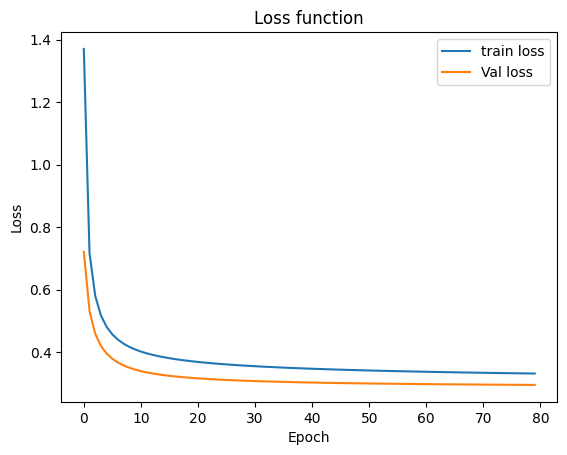

In [129]:
autoencoder3task = Autoencoder_3(784,256,nn.Tanh)
autoencoder_adjuster3 = torch.optim.Adam(autoencoder3task.parameters())

with torch.no_grad():
    autoencoder_train_fts = autoencoder3task(train_fts)[0]
    autoencoder_dev_fts = autoencoder3task(dev_fts)[0]

print(autoencoder_train_fts.shape[1],"au")

model_3 = MyMLP(num_input_dims=autoencoder_train_fts.shape[1], 
                num_neurons=[],
                num_classes=num_labels)

weight_adjuster33 = torch.optim.Adam(model_3.parameters(), lr=0.001)
'''

train1(model_3,autoencoder3task, data_features=train_fts, data_labels=train_labels, 
       weight_adjuster=weight_adjuster33,
       num_epochs=40, batch_size=70, val_features=dev_fts, val_labels=dev_labels,
       epoch_callback=predict_callback(actual=dev_labels,
                                       input_fts=dev_fts,
                                       model=model_3))

'''
train(model_3, data_features=autoencoder_train_fts, data_labels=train_labels, 
       weight_adjuster=weight_adjuster33,
       num_epochs=80, batch_size=100, val_features=autoencoder_dev_fts, val_labels=dev_labels,
       epoch_callback=predict_callback(actual=dev_labels,
                                       input_fts=autoencoder_dev_fts,
                                       model=model_3))


In [130]:
x_pred=model_3.predict(autoencoder3task(test_fts)[0])
import numpy as np

matches = [1 if a == b else 0 for a, b in zip(x_pred, test_labels)]
total_matches = sum(matches)

print(f"Accuracy: {total_matches/10000:.4f}%")

torch.Size([10000, 256])
torch.Size([10000, 10])
Accuracy: 0.9191%


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


[784]
[10]
[10] outs
784 :i o: 10
Epoch 0


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.8994
Epoch loss: 0.765043
Val loss: 0.389602
Epoch 1


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9130000000000001
Epoch loss: 0.420721
Val loss: 0.327291
Epoch 2


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9173000000000001
Epoch loss: 0.373244
Val loss: 0.304289
Epoch 3


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.92
Epoch loss: 0.350861
Val loss: 0.292387
Epoch 4


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9219
Epoch loss: 0.337280
Val loss: 0.285213
Epoch 5


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9228
Epoch loss: 0.327937
Val loss: 0.280478
Epoch 6


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.924
Epoch loss: 0.320992
Val loss: 0.277155
Epoch 7


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.924
Epoch loss: 0.315548
Val loss: 0.274718
Epoch 8


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9243999999999999
Epoch loss: 0.311116
Val loss: 0.272876
Epoch 9


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9248
Epoch loss: 0.307405
Val loss: 0.271453
Epoch 10


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9254
Epoch loss: 0.304228
Val loss: 0.270336
Epoch 11


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9258
Epoch loss: 0.301464
Val loss: 0.269452
Epoch 12


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9266
Epoch loss: 0.299026
Val loss: 0.268749
Epoch 13


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9269
Epoch loss: 0.296850
Val loss: 0.268190
Epoch 14


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9271999999999999
Epoch loss: 0.294891
Val loss: 0.267748
Epoch 15


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9276
Epoch loss: 0.293113
Val loss: 0.267401
Epoch 16


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9282
Epoch loss: 0.291488
Val loss: 0.267135
Epoch 17


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.928
Epoch loss: 0.289994
Val loss: 0.266936
Epoch 18


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9278
Epoch loss: 0.288614
Val loss: 0.266794
Epoch 19


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.928
Epoch loss: 0.287333
Val loss: 0.266701
Epoch 20


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9281000000000001
Epoch loss: 0.286139
Val loss: 0.266650
Epoch 21


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9283
Epoch loss: 0.285022
Val loss: 0.266636
Epoch 22


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9281000000000001
Epoch loss: 0.283973
Val loss: 0.266654
Epoch 23


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9282
Epoch loss: 0.282985
Val loss: 0.266700
Epoch 24


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9285
Epoch loss: 0.282053
Val loss: 0.266770
Epoch 25


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9288
Epoch loss: 0.281171
Val loss: 0.266862
Epoch 26


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9291000000000001
Epoch loss: 0.280334
Val loss: 0.266973
Epoch 27


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.929
Epoch loss: 0.279538
Val loss: 0.267101
Epoch 28


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9291000000000001
Epoch loss: 0.278780
Val loss: 0.267244
Epoch 29


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9291000000000001
Epoch loss: 0.278056
Val loss: 0.267401
Epoch 30


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9291000000000001
Epoch loss: 0.277364
Val loss: 0.267569
Epoch 31


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9294
Epoch loss: 0.276702
Val loss: 0.267748
Epoch 32


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9292
Epoch loss: 0.276067
Val loss: 0.267937
Epoch 33


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9289
Epoch loss: 0.275457
Val loss: 0.268134
Epoch 34


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9287
Epoch loss: 0.274870
Val loss: 0.268339
Epoch 35


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9287
Epoch loss: 0.274306
Val loss: 0.268550
Epoch 36


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9286
Epoch loss: 0.273762
Val loss: 0.268768
Epoch 37


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9285
Epoch loss: 0.273236
Val loss: 0.268991
Epoch 38


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9284
Epoch loss: 0.272729
Val loss: 0.269218
Epoch 39


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9284
Epoch loss: 0.272238
Val loss: 0.269450
Epoch 40


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9284
Epoch loss: 0.271764
Val loss: 0.269685
Epoch 41


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9285
Epoch loss: 0.271304
Val loss: 0.269924
Epoch 42


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9287
Epoch loss: 0.270858
Val loss: 0.270166
Epoch 43


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9286
Epoch loss: 0.270425
Val loss: 0.270410
Epoch 44


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9284
Epoch loss: 0.270005
Val loss: 0.270656
Epoch 45


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9284
Epoch loss: 0.269597
Val loss: 0.270904
Epoch 46


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9282
Epoch loss: 0.269200
Val loss: 0.271154
Epoch 47


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9282
Epoch loss: 0.268814
Val loss: 0.271405
Epoch 48


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9282
Epoch loss: 0.268438
Val loss: 0.271657
Epoch 49


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9282
Epoch loss: 0.268072
Val loss: 0.271911
Epoch 50


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9282
Epoch loss: 0.267715
Val loss: 0.272165
Epoch 51


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.928
Epoch loss: 0.267366
Val loss: 0.272420
Epoch 52


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9279
Epoch loss: 0.267026
Val loss: 0.272675
Epoch 53


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9278
Epoch loss: 0.266695
Val loss: 0.272930
Epoch 54


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9276
Epoch loss: 0.266370
Val loss: 0.273186
Epoch 55


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9276
Epoch loss: 0.266054
Val loss: 0.273442
Epoch 56


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9276
Epoch loss: 0.265744
Val loss: 0.273699
Epoch 57


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9275
Epoch loss: 0.265441
Val loss: 0.273955
Epoch 58


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9274
Epoch loss: 0.265144
Val loss: 0.274211
Epoch 59


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9276
Epoch loss: 0.264854
Val loss: 0.274466
Epoch 60


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9274
Epoch loss: 0.264570
Val loss: 0.274722
Epoch 61


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9273
Epoch loss: 0.264292
Val loss: 0.274977
Epoch 62


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9274
Epoch loss: 0.264019
Val loss: 0.275232
Epoch 63


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9274
Epoch loss: 0.263751
Val loss: 0.275486
Epoch 64


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9273
Epoch loss: 0.263489
Val loss: 0.275740
Epoch 65


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9271999999999999
Epoch loss: 0.263232
Val loss: 0.275994
Epoch 66


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9273
Epoch loss: 0.262979
Val loss: 0.276247
Epoch 67


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9273
Epoch loss: 0.262731
Val loss: 0.276499
Epoch 68


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9271999999999999
Epoch loss: 0.262488
Val loss: 0.276751
Epoch 69


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9274
Epoch loss: 0.262249
Val loss: 0.277002
Epoch 70


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9274
Epoch loss: 0.262014
Val loss: 0.277252
Epoch 71


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9273
Epoch loss: 0.261784
Val loss: 0.277502
Epoch 72


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.927
Epoch loss: 0.261557
Val loss: 0.277751
Epoch 73


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.927
Epoch loss: 0.261334
Val loss: 0.278000
Epoch 74


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9268
Epoch loss: 0.261115
Val loss: 0.278247
Epoch 75


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9267
Epoch loss: 0.260899
Val loss: 0.278494
Epoch 76


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9265
Epoch loss: 0.260687
Val loss: 0.278740
Epoch 77


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9264
Epoch loss: 0.260478
Val loss: 0.278985
Epoch 78


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9265
Epoch loss: 0.260273
Val loss: 0.279230
Epoch 79


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


torch.Size([10000, 784])
torch.Size([10000, 10])
f1 score: 0.9264
Epoch loss: 0.260071
Val loss: 0.279474


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)


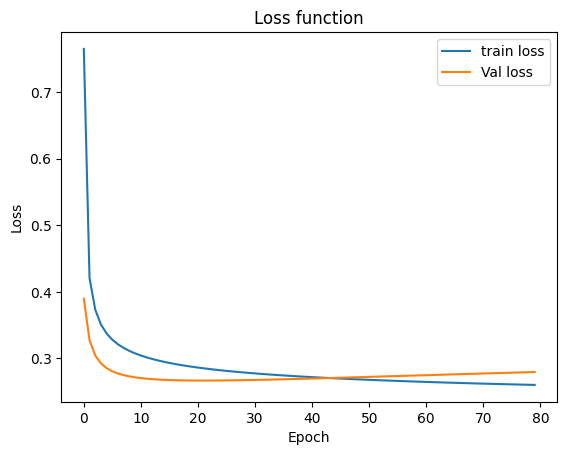

In [131]:
model_3_1 = MyMLP(num_input_dims=train_fts.shape[1], 
                num_neurons=[],
                num_classes=num_labels)

weight_adjuster331 = torch.optim.Adam(model_3_1.parameters(), lr=0.001)

train(model_3_1, data_features=train_fts, data_labels=train_labels, 
       weight_adjuster=weight_adjuster331,
       num_epochs=80, batch_size=100, val_features=dev_fts, val_labels=dev_labels,
       epoch_callback=predict_callback(actual=dev_labels,
                                       input_fts=dev_fts,
                                       model=model_3_1))

In [132]:
x_pred=model_3_1.predict(test_fts)
import numpy as np

matches = [1 if a == b else 0 for a, b in zip(x_pred, test_labels)]
total_matches = sum(matches)

print(f"Accuracy: {total_matches/10000:.4f}%")

torch.Size([10000, 784])
torch.Size([10000, 10])
Accuracy: 0.9264%


<ipython-input-10-e44211bf9fb2>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = fn(h)
